In [ ]:
!pip install pennylane-qiskit

!pip install scikit-learn

# Quantum Reservoir Computing Algorithm for Credit Card Fraud Detection

## Step 1: Load and Preprocess Data
1. **Load Dataset**:
   - Load credit card dataset from the file.
   - Assign meaningful column names for clarity.
2. **Preprocess Data**:
   - Split the data into features (`X`) and target (`y`).
   - Normalize features to the range $([0, \pi]$) for compatibility with quantum gates.
   - Apply **Principal Component Analysis (PCA)** to reduce the feature dimension to match the number of qubits in the quantum reservoir.




In [2]:
# Load and inspect the uploaded file to understand its structure
file_path = '/kaggle/input/credit-card-data/german.data-numeric'

# Attempt to load the file and preview its contents
with open(file_path, 'r') as file:
    data_preview = file.readlines()

# Display the first few lines to understand the format
data_preview[:10] 

['   1   6   4  12   5   5   3   4   1  67   3   2   1   2   1   0   0   1   0   0   1   0   0   1   1 \n',
 '   2  48   2  60   1   3   2   2   1  22   3   1   1   1   1   0   0   1   0   0   1   0   0   1   2 \n',
 '   4  12   4  21   1   4   3   3   1  49   3   1   2   1   1   0   0   1   0   0   1   0   1   0   1 \n',
 '   1  42   2  79   1   4   3   4   2  45   3   1   2   1   1   0   0   0   0   0   0   0   0   1   1 \n',
 '   1  24   3  49   1   3   3   4   4  53   3   2   2   1   1   1   0   1   0   0   0   0   0   1   2 \n',
 '   4  36   2  91   5   3   3   4   4  35   3   1   2   2   1   0   0   1   0   0   0   0   1   0   1 \n',
 '   4  24   2  28   3   5   3   4   2  53   3   1   1   1   1   0   0   1   0   0   1   0   0   1   1 \n',
 '   2  36   2  69   1   3   3   2   3  35   3   1   1   2   1   0   1   1   0   1   0   0   0   0   1 \n',
 '   4  12   2  31   4   4   1   4   1  61   3   1   1   1   1   0   0   1   0   0   1   0   1   0   1 \n',
 '   2  30   4  52   1   1  

In [3]:
import pandas as pd

# File path
file_path = '/kaggle/input/credit-card-data/german.data-numeric'

# Step 1: Read the file and preview the first few lines
with open(file_path, 'r') as file:
    data_lines = file.readlines()

# Step 2: Clean the data
# Strip leading and trailing spaces and split by whitespace
cleaned_data = [line.strip().split() for line in data_lines]

# Step 3: Convert the cleaned data into a DataFrame
df = pd.DataFrame(cleaned_data)

# Optionally: Convert all columns to numeric values if needed
df = df.apply(pd.to_numeric)

df # Preview the first few rows to confirm the structure


0   1   2   3   4   5   6   7   8   9   ...  15  16  17  18  19  20  21  \
0     1   6   4  12   5   5   3   4   1  67  ...   0   0   1   0   0   1   0   
1     2  48   2  60   1   3   2   2   1  22  ...   0   0   1   0   0   1   0   
2     4  12   4  21   1   4   3   3   1  49  ...   0   0   1   0   0   1   0   
3     1  42   2  79   1   4   3   4   2  45  ...   0   0   0   0   0   0   0   
4     1  24   3  49   1   3   3   4   4  53  ...   1   0   1   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
995   4  12   2  17   1   4   2   4   1  31  ...   0   0   1   0   0   1   0   
996   1  30   2  39   1   3   1   4   2  40  ...   0   1   1   0   0   1   0   
997   4  12   2   8   1   5   3   4   3  38  ...   0   0   1   0   0   1   0   
998   1  45   2  18   1   3   3   4   4  23  ...   0   0   1   0   0   0   0   
999   2  45   4  46   2   1   3   4   3  27  ...   0   1   1   0   0   1   0   

     22  23  24  
0     0   1   1  
1     0   1   2  
2     1   0   1  
3     0   1   1  
4     0   1   2  
..   ..  ..  ..  
995   1   0   1  
996   0   0   1  
997   0   1   1  
998   0   1   2  
999   0   1   1  

[1000 rows x 25 columns]

In [4]:
df.columns = [f"Feature_{i+1}" for i in range(df.shape[1])]
df = df.rename(columns={'Feature_25': 'Target'})
df

Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0            1          6          4         12          5          5   
1            2         48          2         60          1          3   
2            4         12          4         21          1          4   
3            1         42          2         79          1          4   
4            1         24          3         49          1          3   
..         ...        ...        ...        ...        ...        ...   
995          4         12          2         17          1          4   
996          1         30          2         39          1          3   
997          4         12          2          8          1          5   
998          1         45          2         18          1          3   
999          2         45          4         46          2          1   

     Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_16  Feature_17  \
0            3          4          1          67  ...           0           0   
1            2          2          1          22  ...           0           0   
2            3          3          1          49  ...           0           0   
3            3          4          2          45  ...           0           0   
4            3          4          4          53  ...           1           0   
..         ...        ...        ...         ...  ...         ...         ...   
995          2          4          1          31  ...           0           0   
996          1          4          2          40  ...           0           1   
997          3          4          3          38  ...           0           0   
998          3          4          4          23  ...           0           0   
999          3          4          3          27  ...           0           1   

     Feature_18  Feature_19  Feature_20  Feature_21  Feature_22  Feature_23  \
0             1           0           0           1           0           0   
1             1           0           0           1           0           0   
2             1           0           0           1           0           1   
3             0           0           0           0           0           0   
4             1           0           0           0           0           0   
..          ...         ...         ...         ...         ...         ...   
995           1           0           0           1           0           1   
996           1           0           0           1           0           0   
997           1           0           0           1           0           0   
998           1           0           0           0           0           0   
999           1           0           0           1           0           0   

     Feature_24  Target  
0             1       1  
1             1       2  
2             0       1  
3             1       1  
4             1       2  
..          ...     ...  
995           0       1  
996           0       1  
997           1       1  
998           1       2  
999           1       1  

[1000 rows x 25 columns]

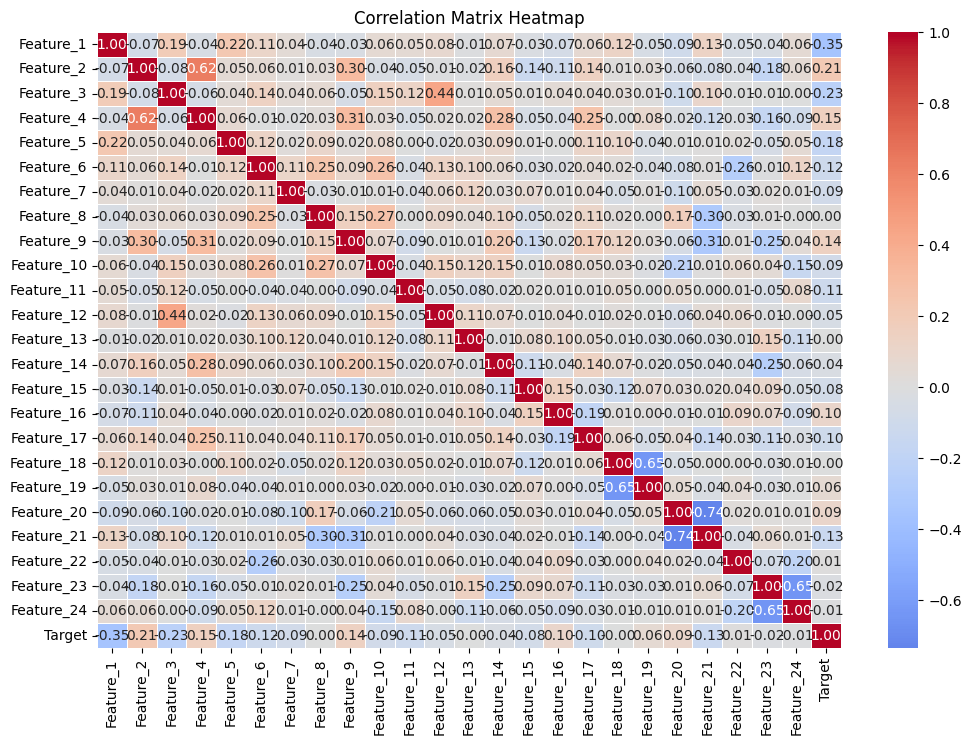

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example: Assuming you already have a DataFrame (df)

# Step 1: Compute the correlation matrix
corr_matrix = df.corr()  # This computes pairwise correlation of all columns in the DataFrame

# Step 2: Create a heatmap
plt.figure(figsize=(12, 8))  # Optional: Adjust the size of the figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center=0)

# Optional: Add title
plt.title("Correlation Matrix Heatmap")

# Show the plot
plt.show()

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Separate features and target
# Split into features and target
X = df.iloc[:, :-1]
y = df["Target"].apply(lambda x: 0 if x == 1 else 1)  # Convert to binary: Good -> 0, Bad -> 1

# Normalize features to the range [0, π]
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_normalized = scaler.fit_transform(X)


# Apply PCA to reduce the feature space to 6 components
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_normalized)

# Split the dataset into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

#print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")




### Step 2: Define the Quantum Reservoir
1. **Quantum Circuit**:
   - Number of qubits: $( n_{\text{qubits}} = 6 $).
   - Number of layers: $( n_{\text{layers}} = 7 $).
2. **Input Encoding**:
   - Use $( R_X $) gates to encode classical features as quantum states.
3. **Reservoir Dynamics**:
   - Add rotational gates ($( R_X, R_Y, R_Z $)) parameterized by random weights for each layer and qubit.
   - Apply entangling gates (CNOT) between adjacent qubits to create correlations.
4. **Measurement**:
   - Compute the expectation value of $( Z $)-operators for each qubit, resulting in a reservoir output vector.

---

In [7]:
import pennylane as qml
# Number of qubits
n_qubits = 6  # You can increase this if you want more expressiveness

# Number of layers in the quantum circuit (increase for complexity)
n_layers = 7  # Increase layers for more complexity

# Define the quantum device using PennyLane's simulator
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def nqs_circuit(inputs, weights):
    # Encoding classical input into quantum state (using RX gates)
    for i in range(n_qubits):
        qml.RX(inputs[i], wires=i)
    
    # Multi-layer quantum circuit
    for l in range(n_layers):
        for i in range(n_qubits):
            # Apply rotation gates with weights for each layer
            qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)
        
        # Apply entangling gates (CNOT) between qubits to generate correlations
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Measure the output (expectation values of PauliZ)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


# Initialize random weights for the variational quantum circuit (for each layer and qubit)
weights = np.random.randn(n_layers, n_qubits, 3)  # 3 parameters per qubit for rotation gates (RX, RY, RZ)


(<Figure size 2800x700 with 1 Axes>, <Axes: >)


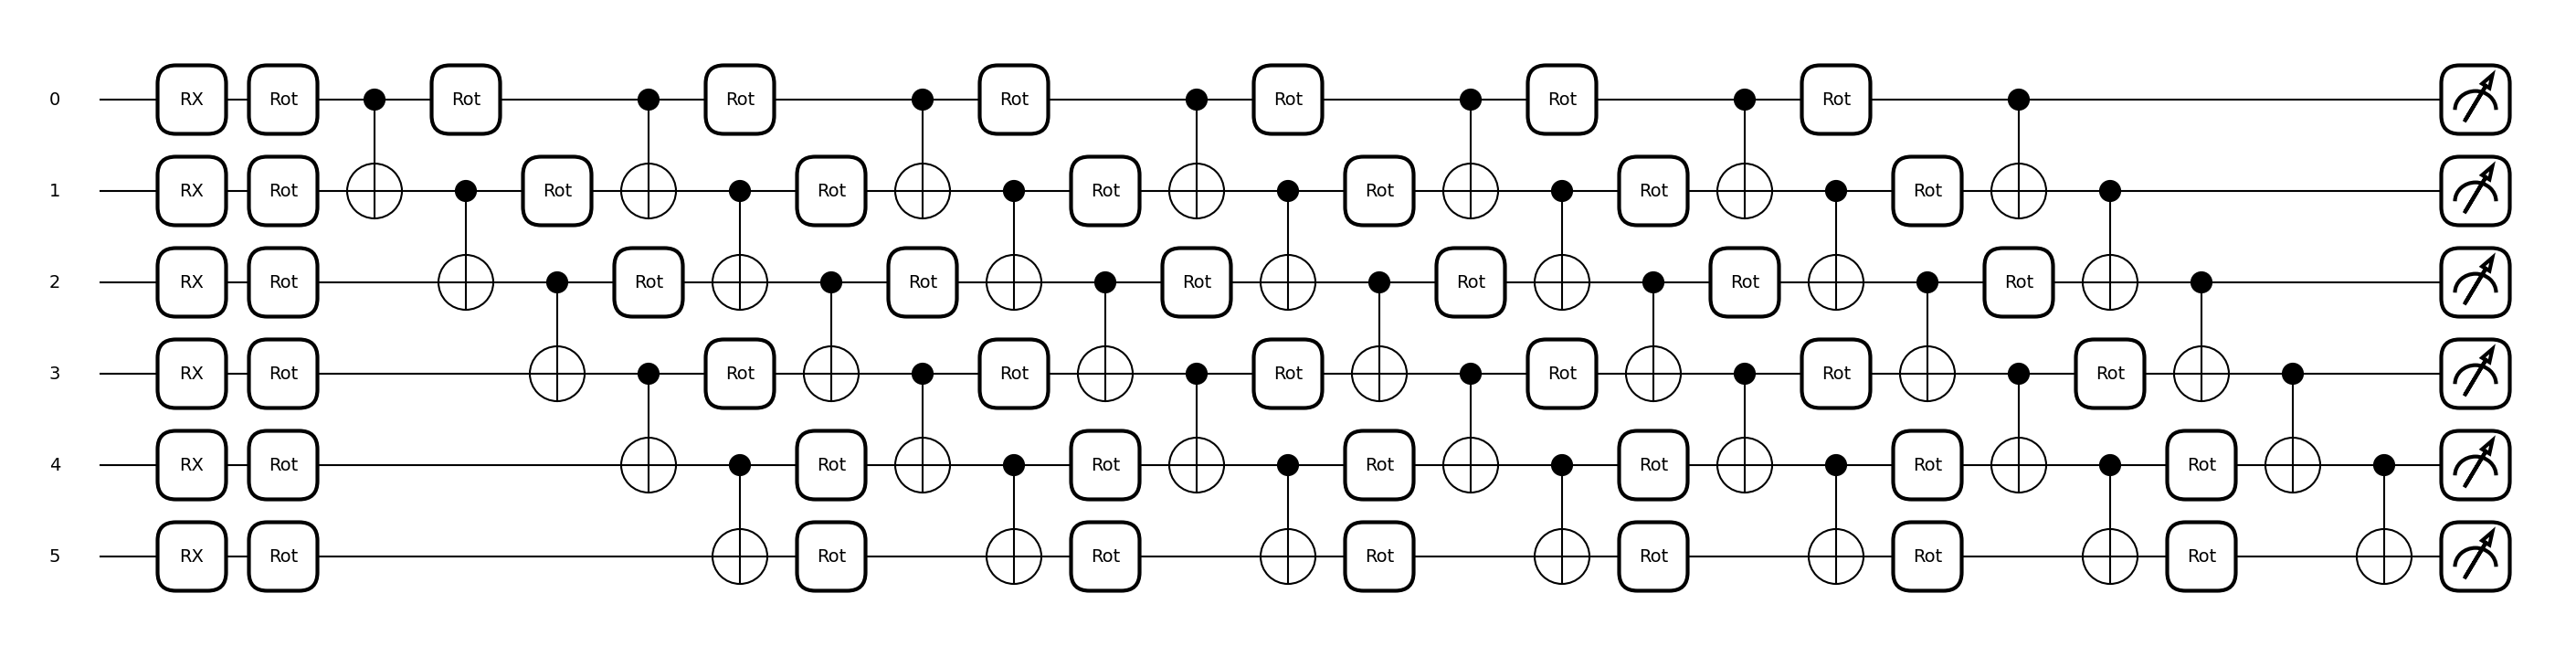

In [8]:
print(qml.draw_mpl(nqs_circuit, expansion_strategy="device")(np.random.random(size=(n_qubits)), weights))

## Step 3: Extract Quantum Reservoir Outputs
1. Pass normalized and PCA-transformed feature vectors through the quantum circuit.
2. Collect the reservoir outputs for all data samples.
1. **Train-Test Split**:
   - Split reservoir outputs and target into training and testing datasets.

In [9]:

# Prepare the input data and output targets for the readout layer
def get_nqs_outputs(X, weights):
    """ Pass the inputs through the NQS to get quantum reservoir outputs """
    reservoir_outputs = []
    for i in range(X.shape[0]):
        inputs = X[i]
        output = nqs_circuit(inputs, weights)
        reservoir_outputs.append(output)
    return np.array(reservoir_outputs)
    
# Get the reservoir outputs from the NQS
X_reservoir = get_nqs_outputs(X_pca, weights)

# Train-test split for the readout layer
X_train, X_test, y_train, y_test = train_test_split(X_reservoir, y, test_size=0.2, random_state=42)



## Step 4: Train Classical Readout Layer

1. Train Classifier: XGBoost or anything else
 
2. Visualise results

## Step 5: Evaluate Performance
1. Use the test set to predict outcomes.
2. Compute performance metrics:
   - **Accuracy**
   - **Recall**
   - **F1-Score**
   
Note: As I have mapped good risk to 0 and bad risk to 1, we do not need to use explicitly write pos_label=1 in the recall_score() method. By default, Scikit-learn assumes the positive class is 1.

In [10]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score


# Train a simple readout model 
readout_model = xgb.XGBClassifier(scale_pos_weight= 10, random_state=42) 
readout_model.fit(X_train, y_train)

# Make predictions
y_pred = readout_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_binary):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_binary):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_binary):.4f}")


Accuracy: 0.6750
Recall: 0.5085
F1-Score: 0.4800


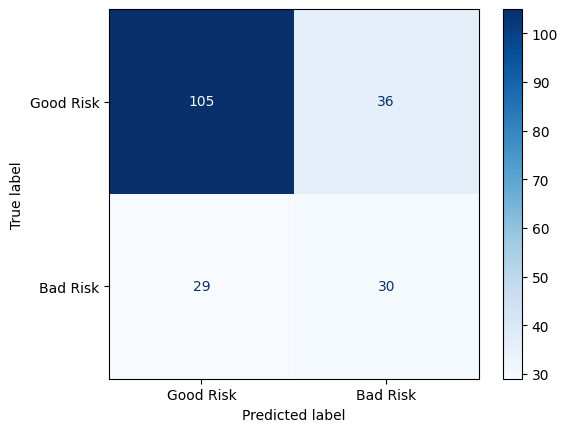

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good Risk", "Bad Risk"])

# Plot the confusion matrix
disp.plot(cmap='Blues')
plt.show()


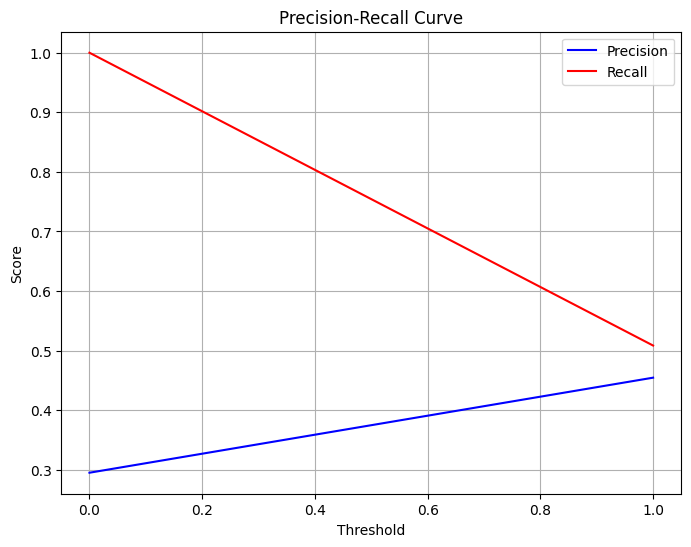

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get precision, recall, and thresholds for the current model
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_binary)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


# Need to do better in recall score for bad risk


## Step 4: Train Classical Readout Layer
1. **Stacking Classifier**:
   - Base classifiers:
     - Logistic Regression
     - Support Vector Machine (SVM)
     - Random Forest
     - XGBoost
   - Final estimator: Logistic Regression. (Others can change this and see what happens)
2. Train the stacking model on reservoir outputs.

## Step 5: Evaluate Performance
1. Use the test set to predict outcomes.
2. Compute performance metrics:
   - **Accuracy**
   - **Recall**
   - **F1-Score**


In [13]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Define base classifiers with class weights (important for imbalanced datasets)
base_learners = [
    ('lr', LogisticRegression(class_weight='balanced', random_state=42)),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('xgb', xgb.XGBClassifier(scale_pos_weight=10, random_state=42))
]

# Define the final estimator with class weights
final_estimator = LogisticRegression(class_weight='balanced', random_state=42)

# Create the stacking model
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=final_estimator)

# Train the model on the training data
stacking_model.fit(X_train, y_train)



# Make predictions on the test set
y_pred_stacking = stacking_model.predict(X_test)

# Evaluate the performance of the stacked model
print(f"Stacking Accuracy: {accuracy_score(y_test, y_pred_stacking):.4f}")
print(f"Stacking Recall: {recall_score(y_test, y_pred_stacking):.4f}")
print(f"Stacking F1-Score: {f1_score(y_test, y_pred_stacking):.4f}")


Stacking Accuracy: 0.6300
Stacking Recall: 0.6271
Stacking F1-Score: 0.5000


## See its better than before. Lets visualise.

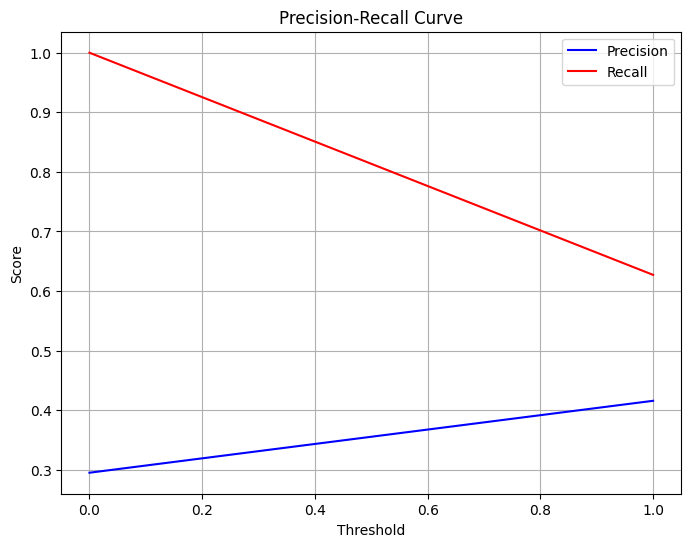

In [14]:
# Get precision, recall, and thresholds for the current model
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_stacking)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


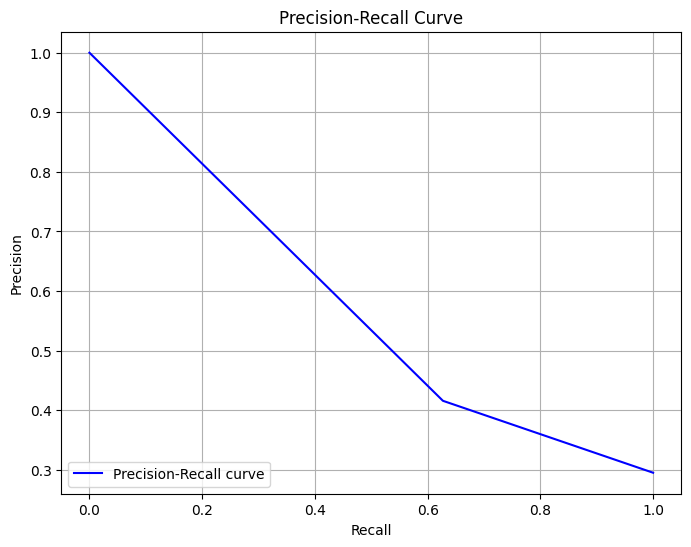

In [15]:
# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_stacking)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_stacking)

# Compute ROC AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


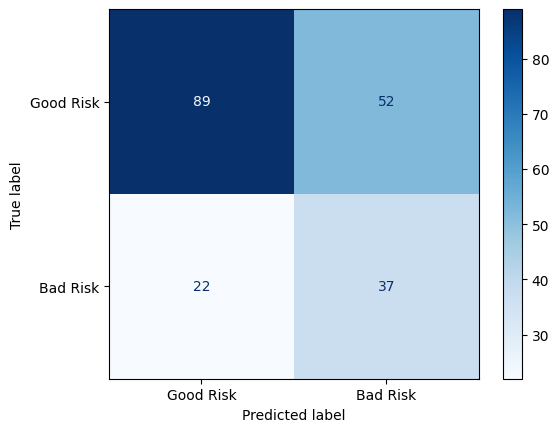

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test,  y_pred_stacking)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good Risk", "Bad Risk"])

# Plot the confusion matrix
disp.plot(cmap='Blues')
plt.show()

### We will run this architecture for 50 times and see if this is a consistent and robust model.

1. Weights of all parameterized gates will be randomized for each run 

<ipython-input-18-022ed6230053>:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 16))


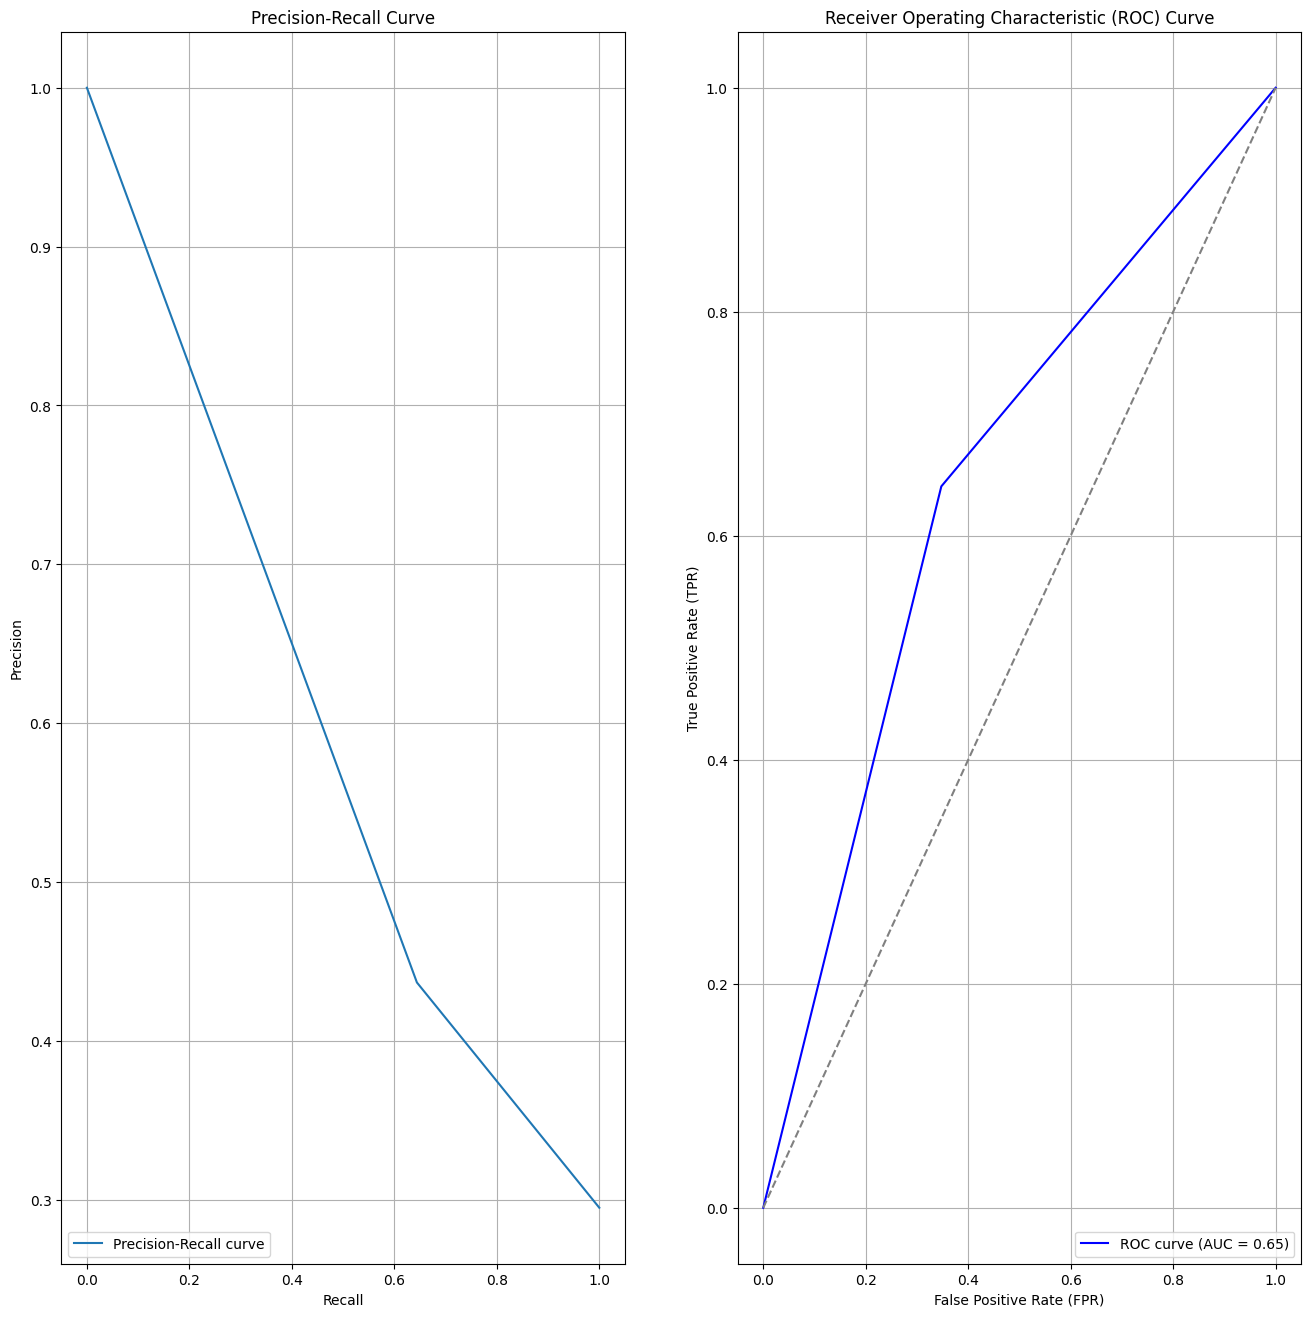

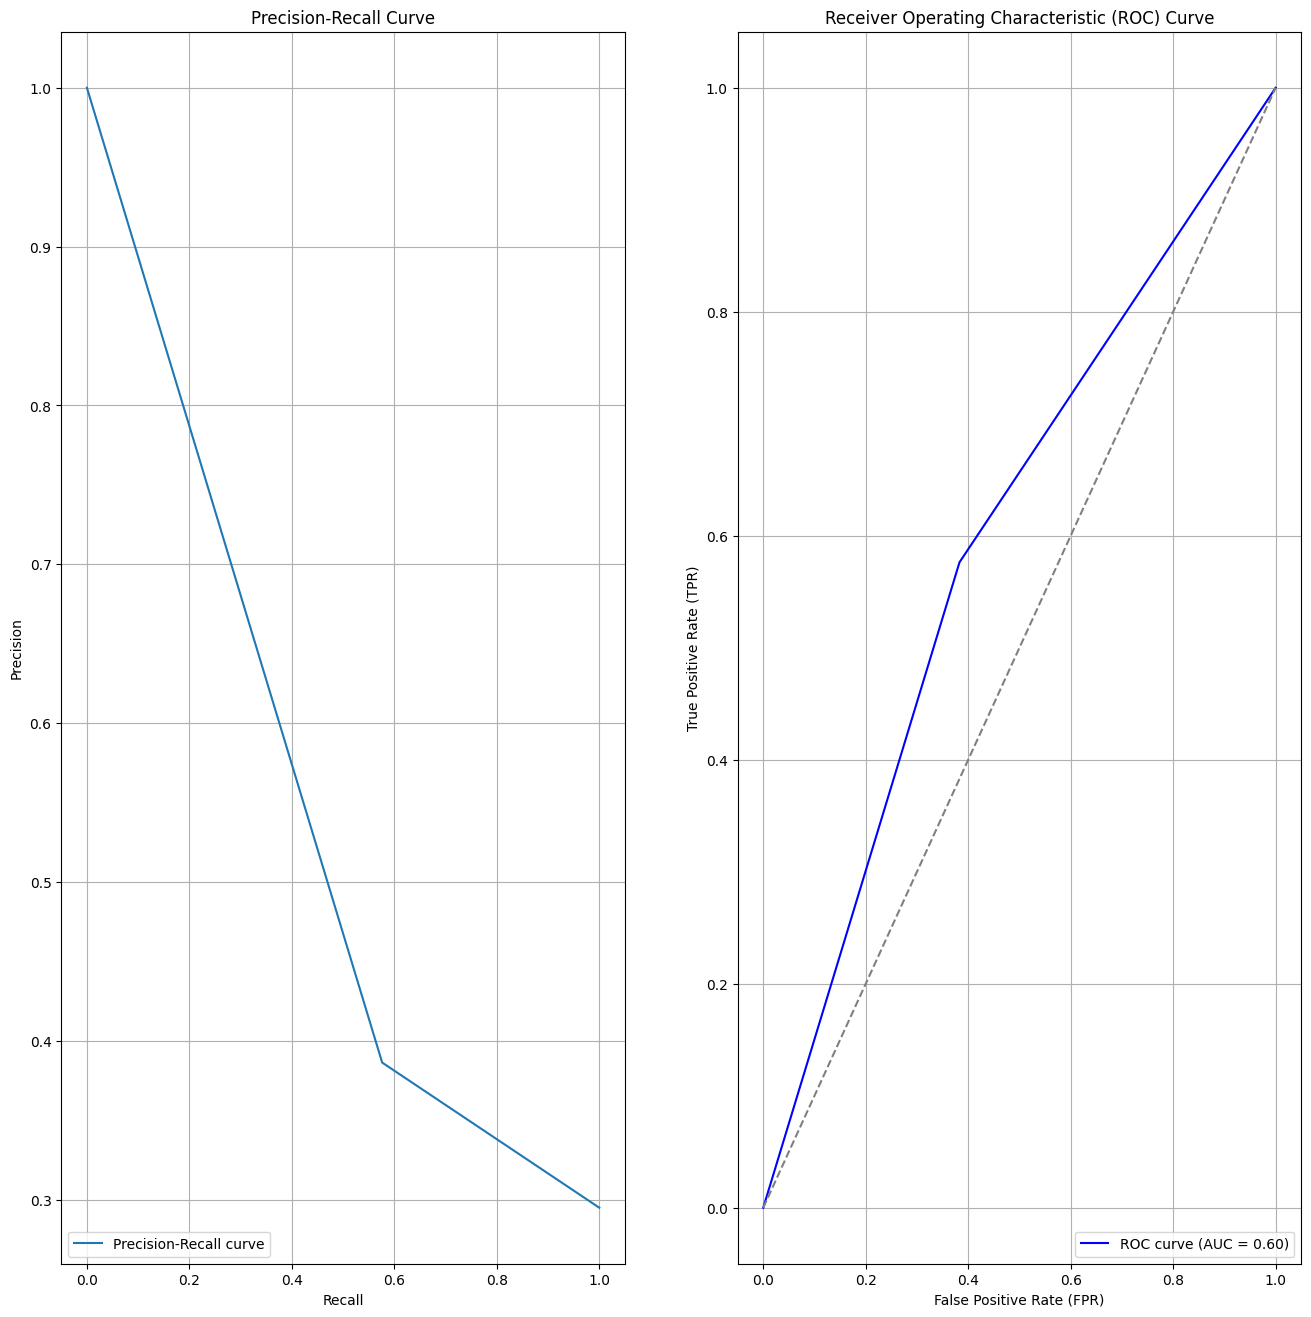

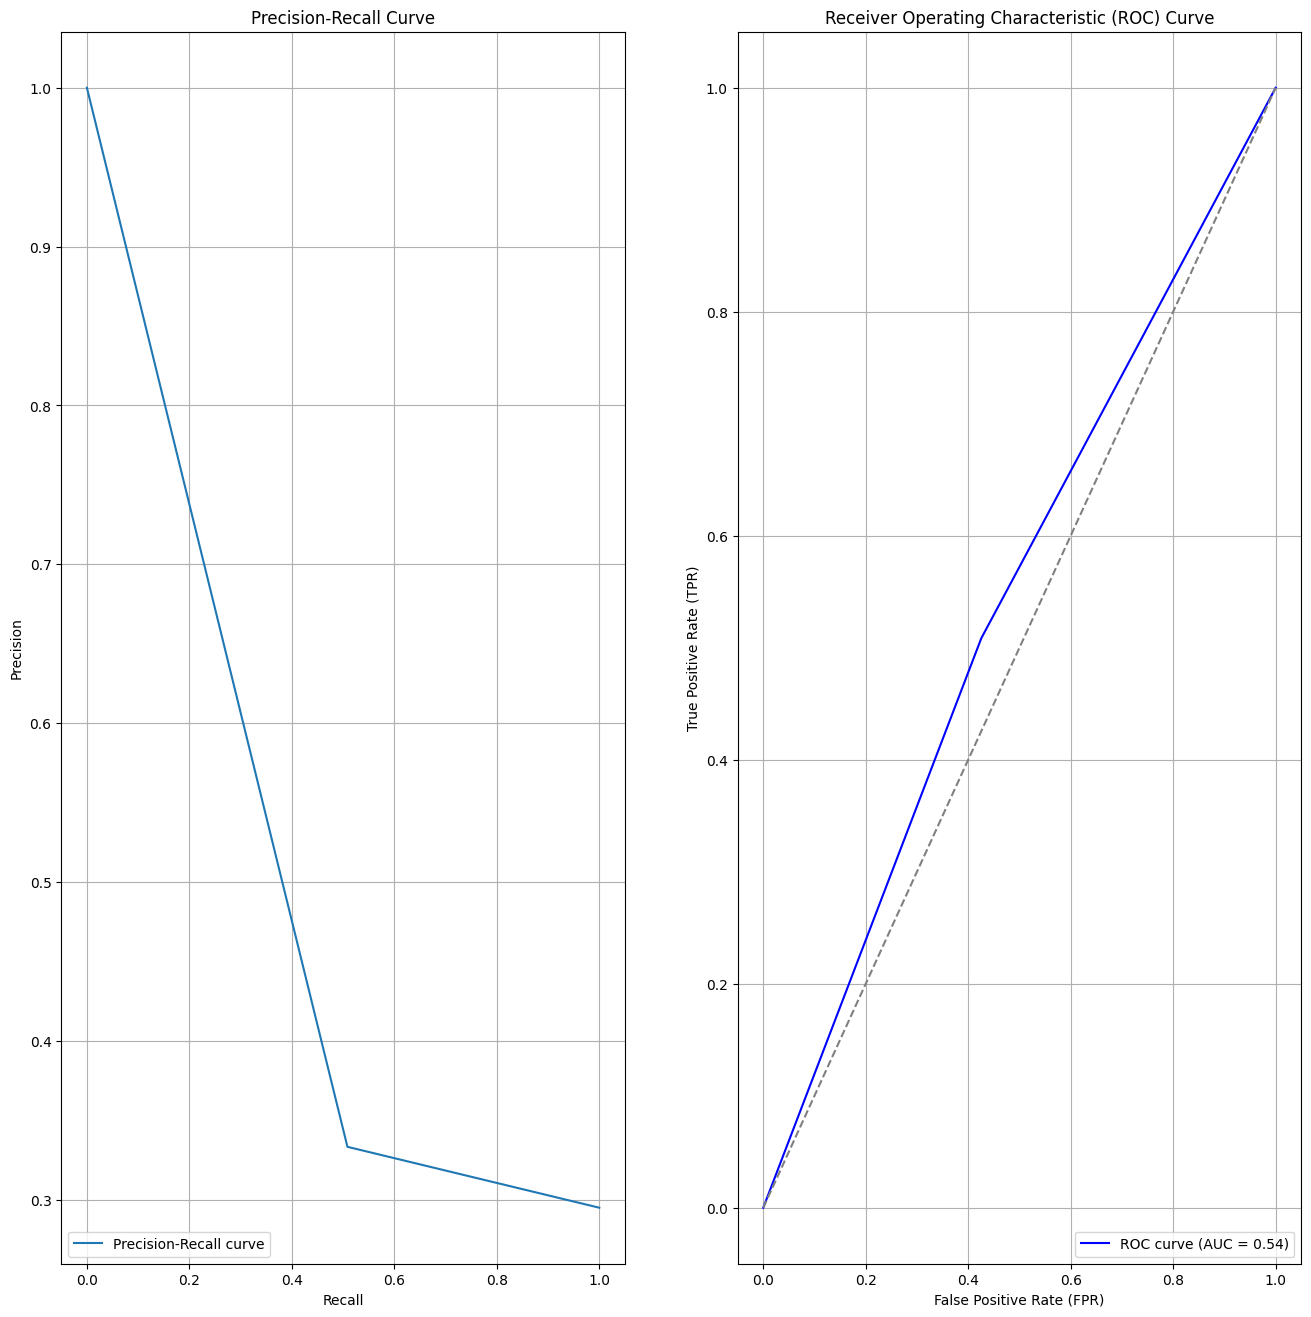

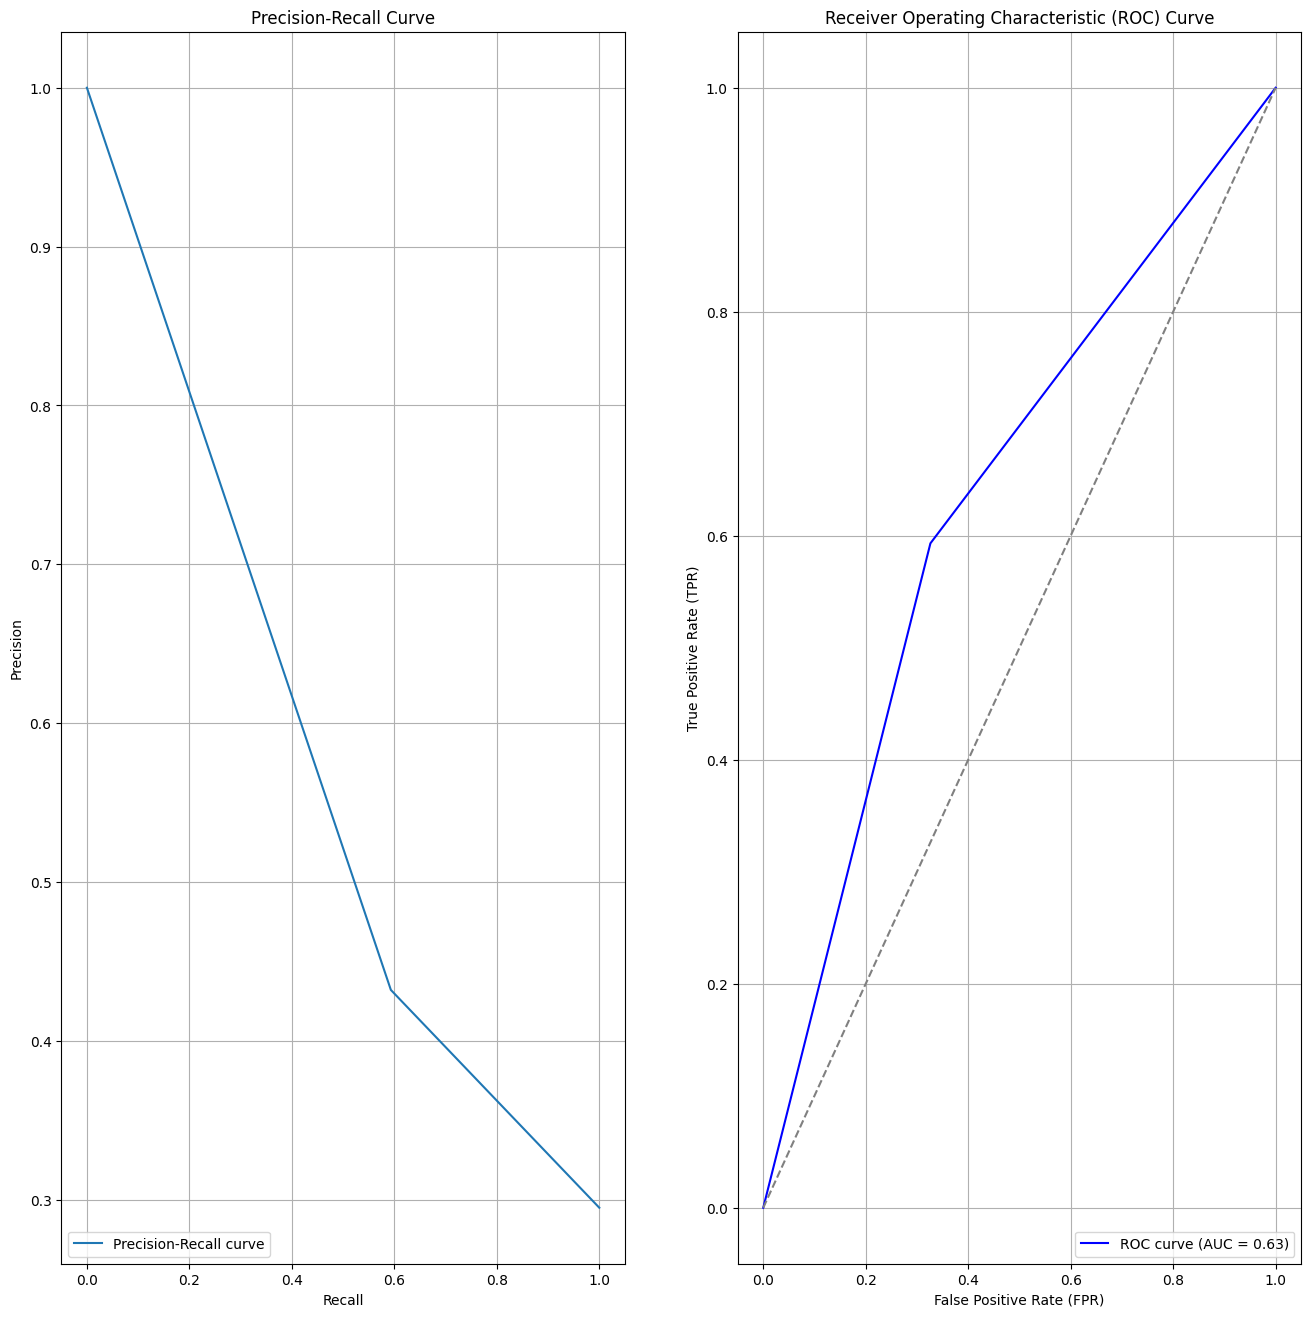

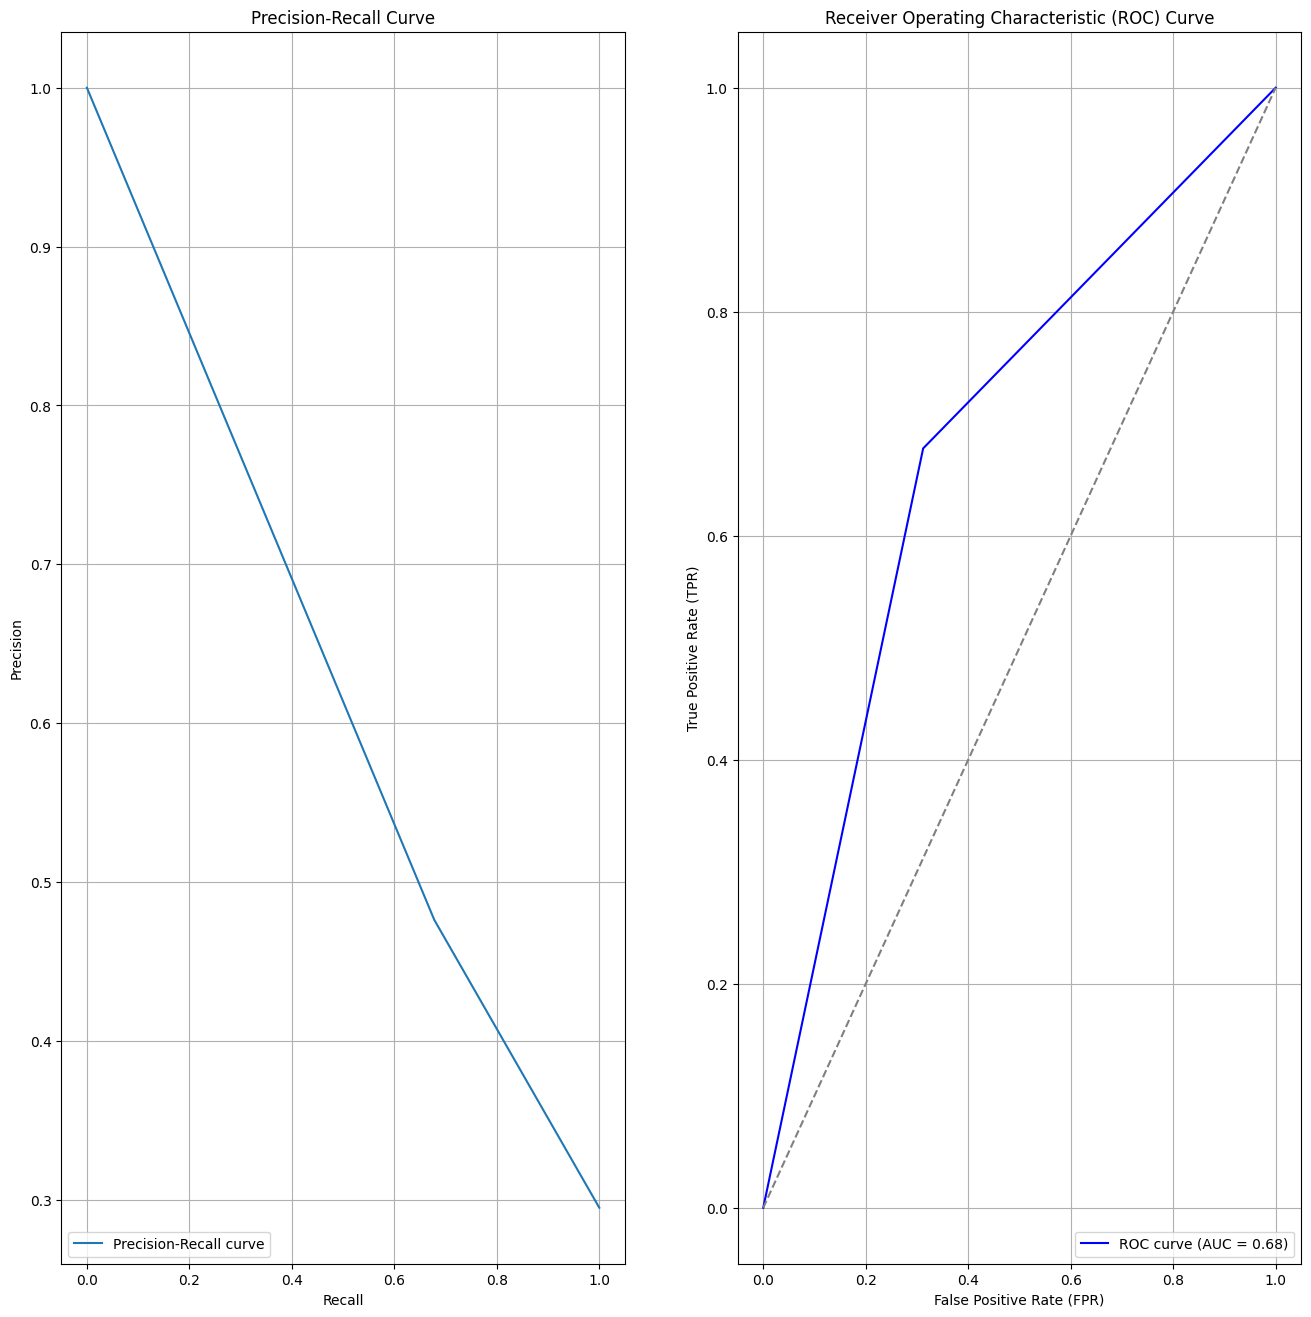

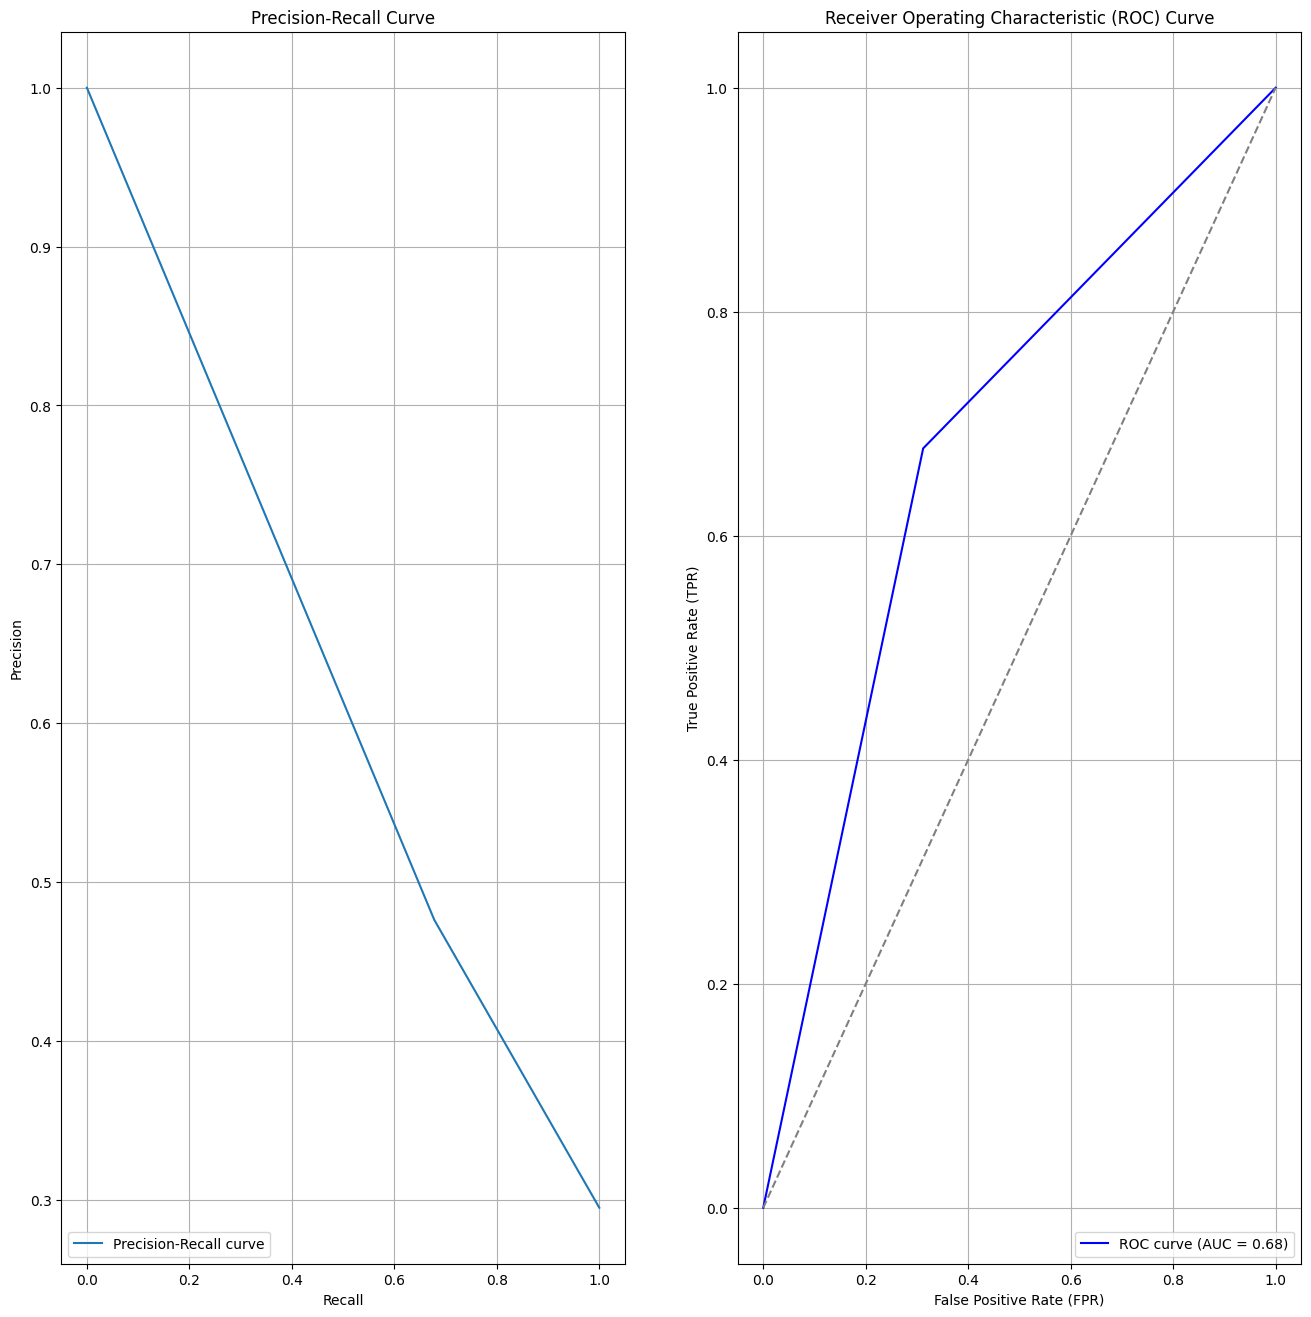

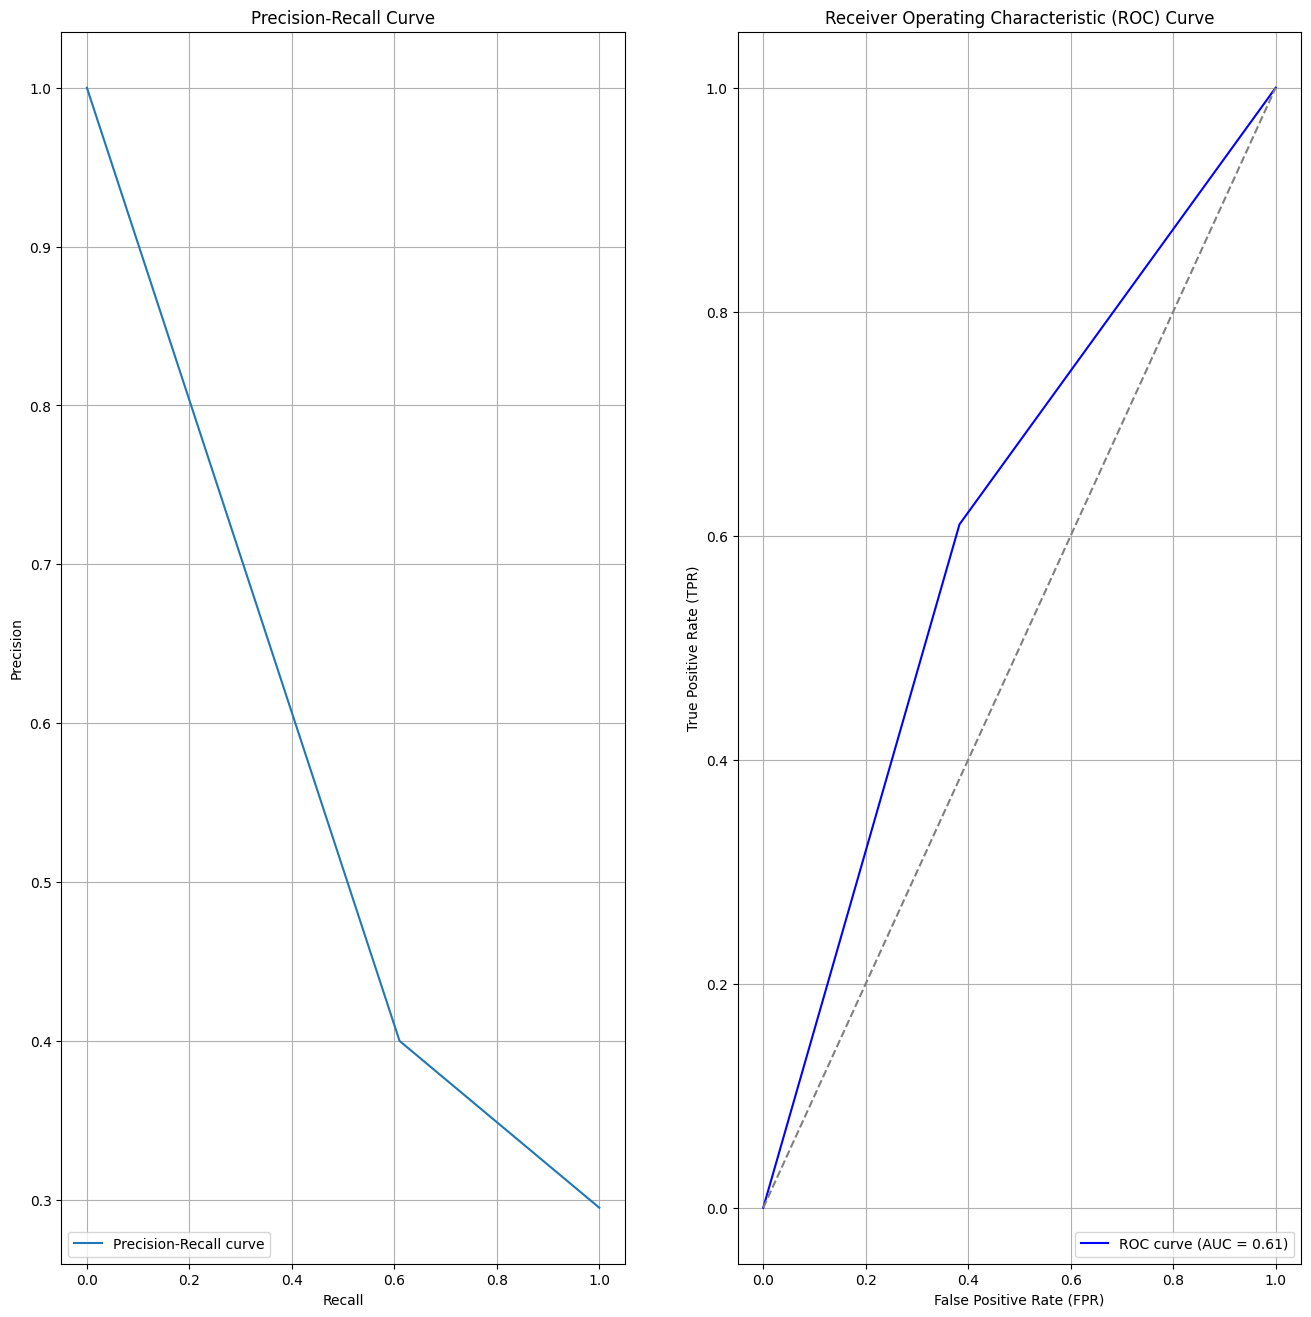

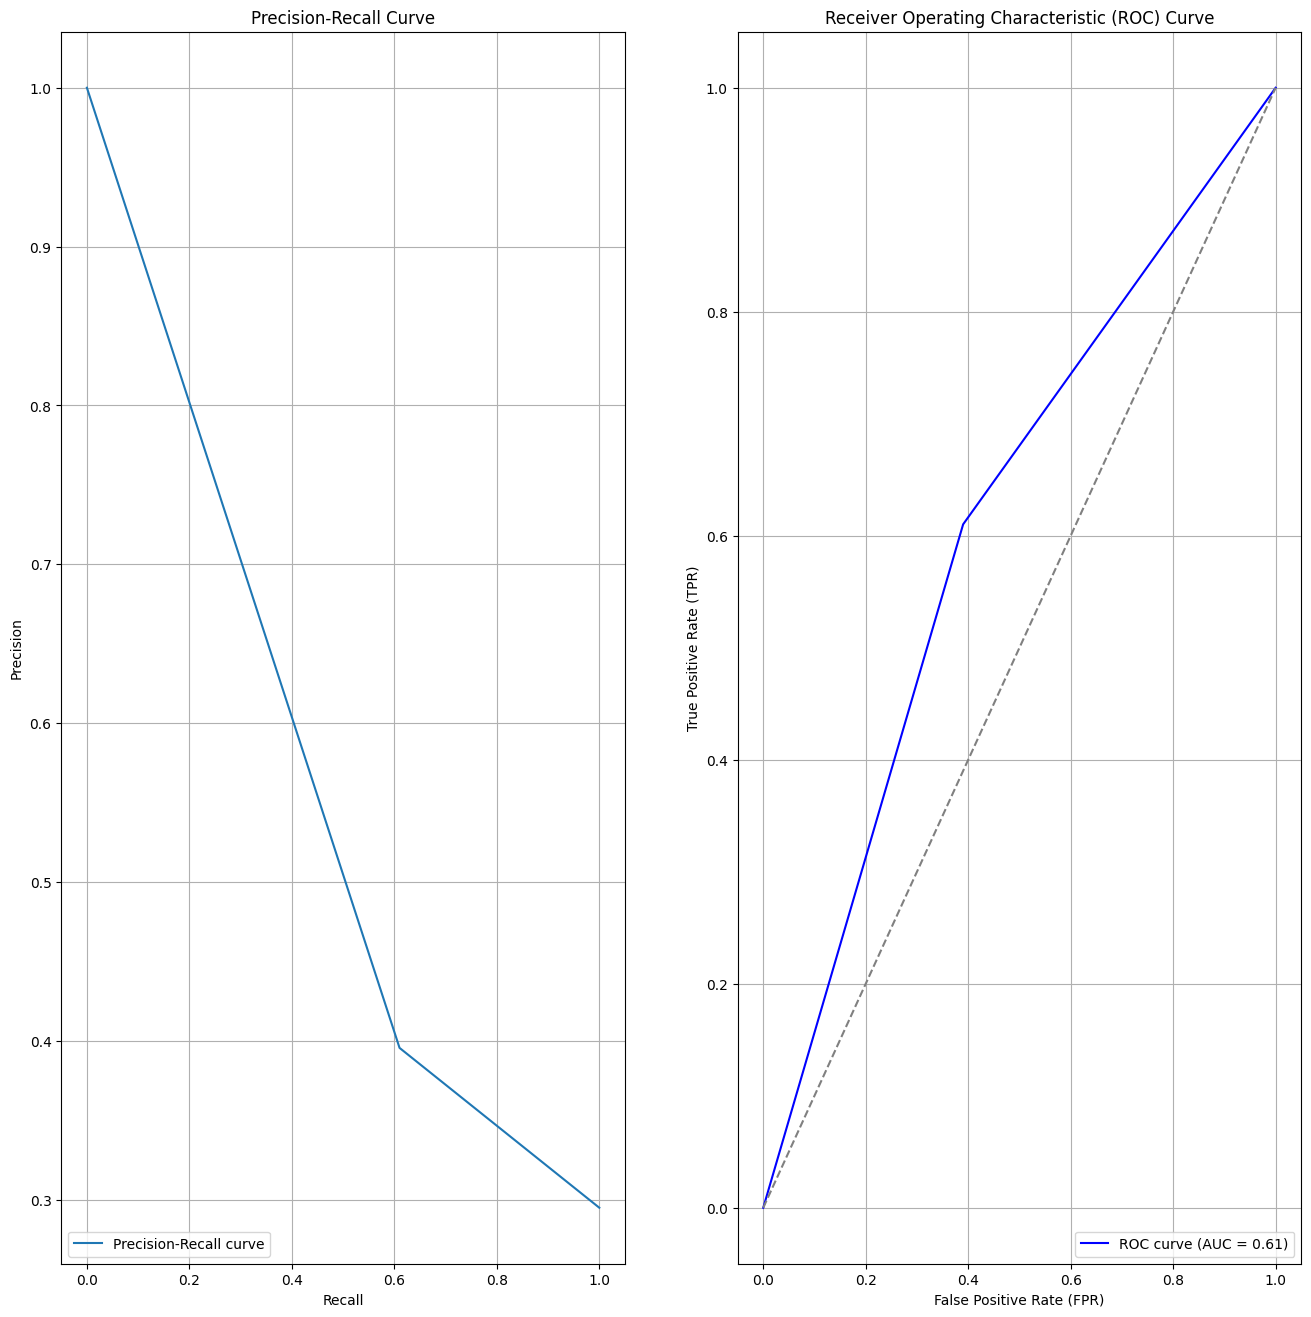

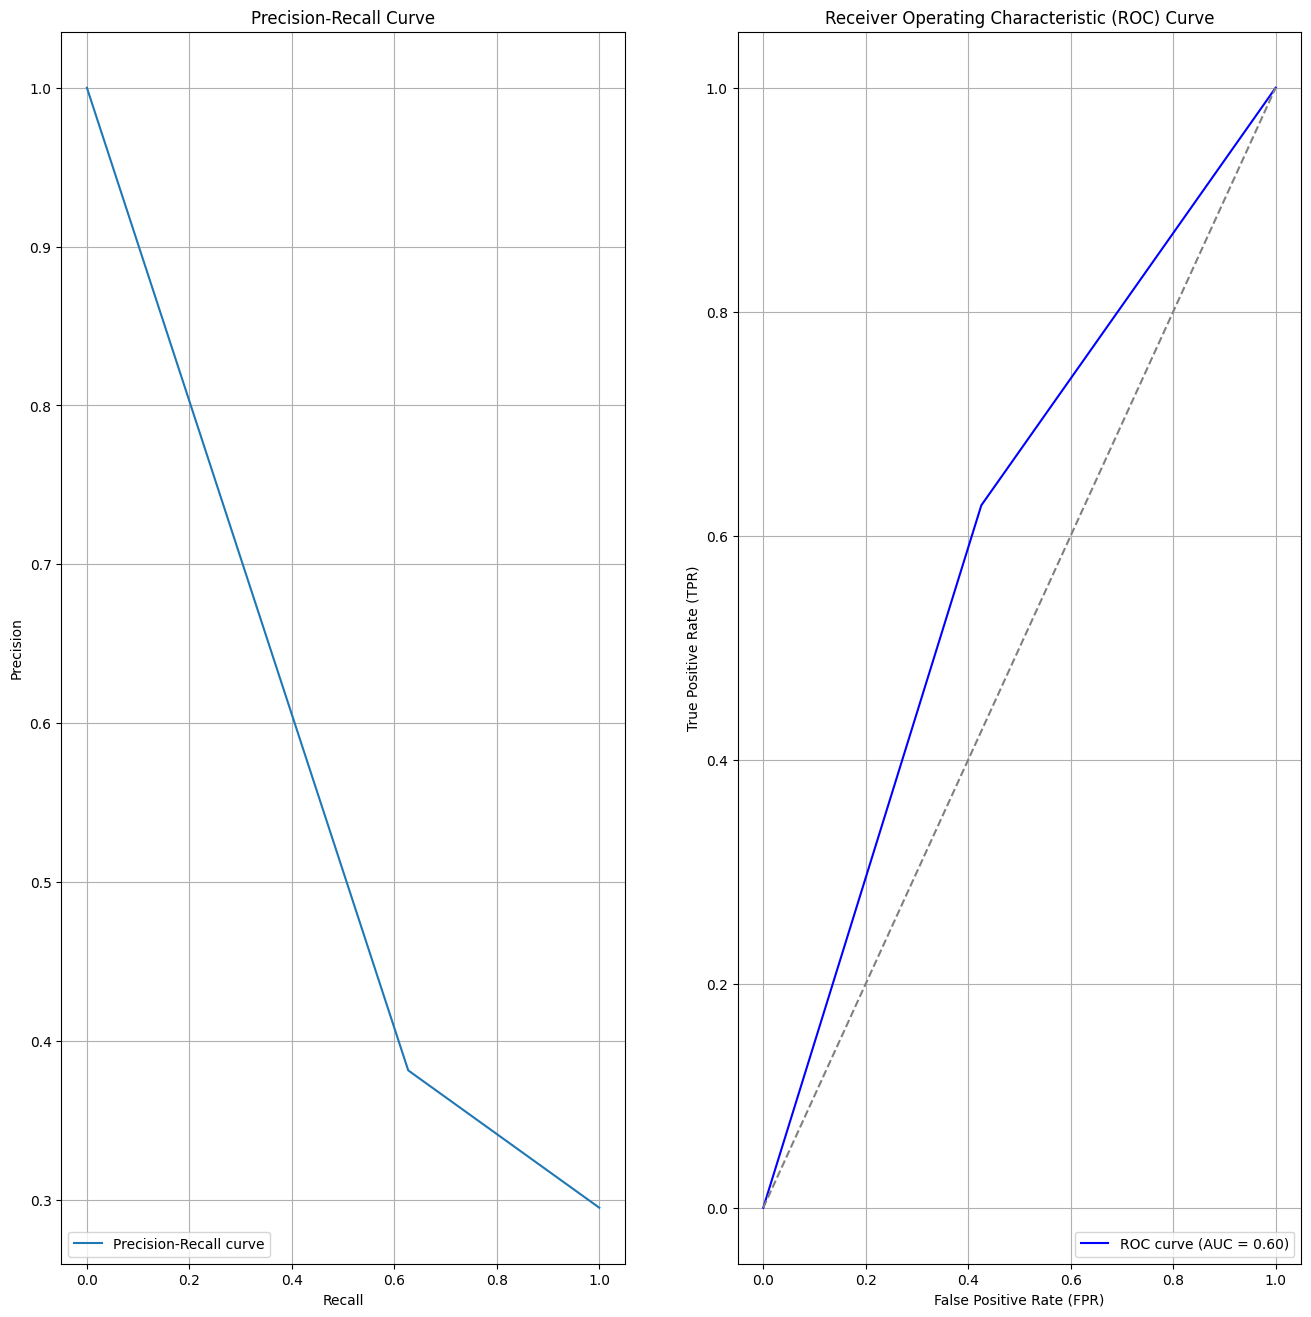

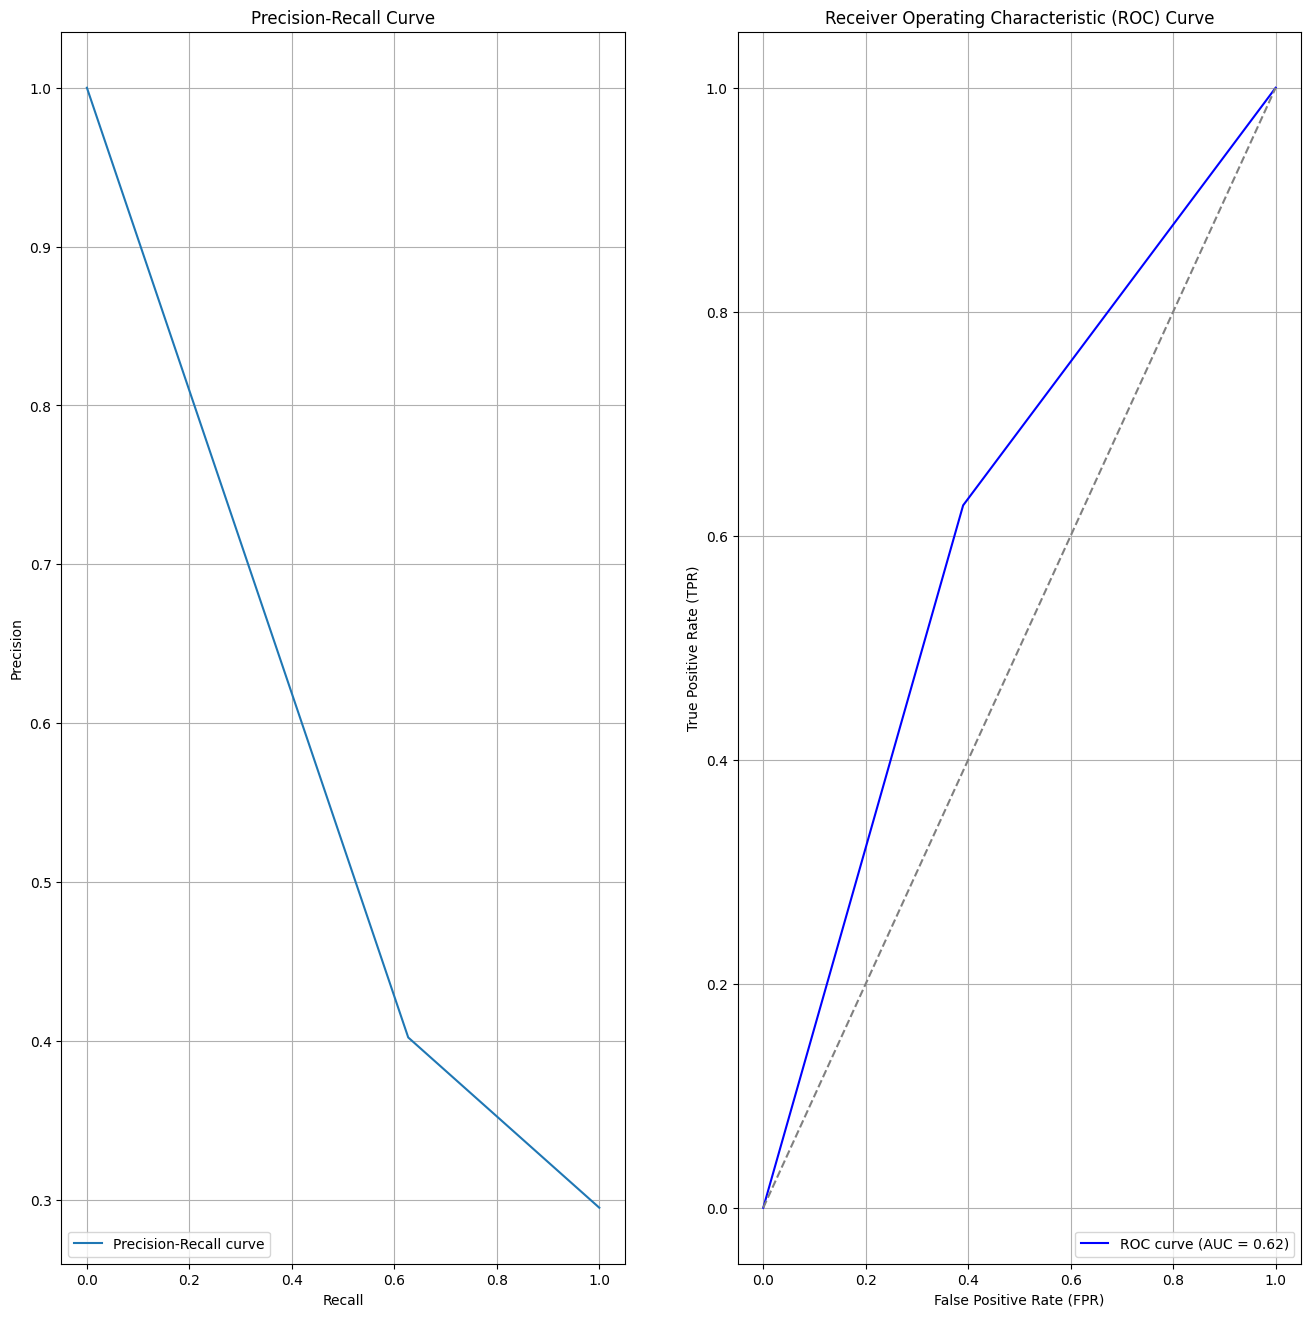

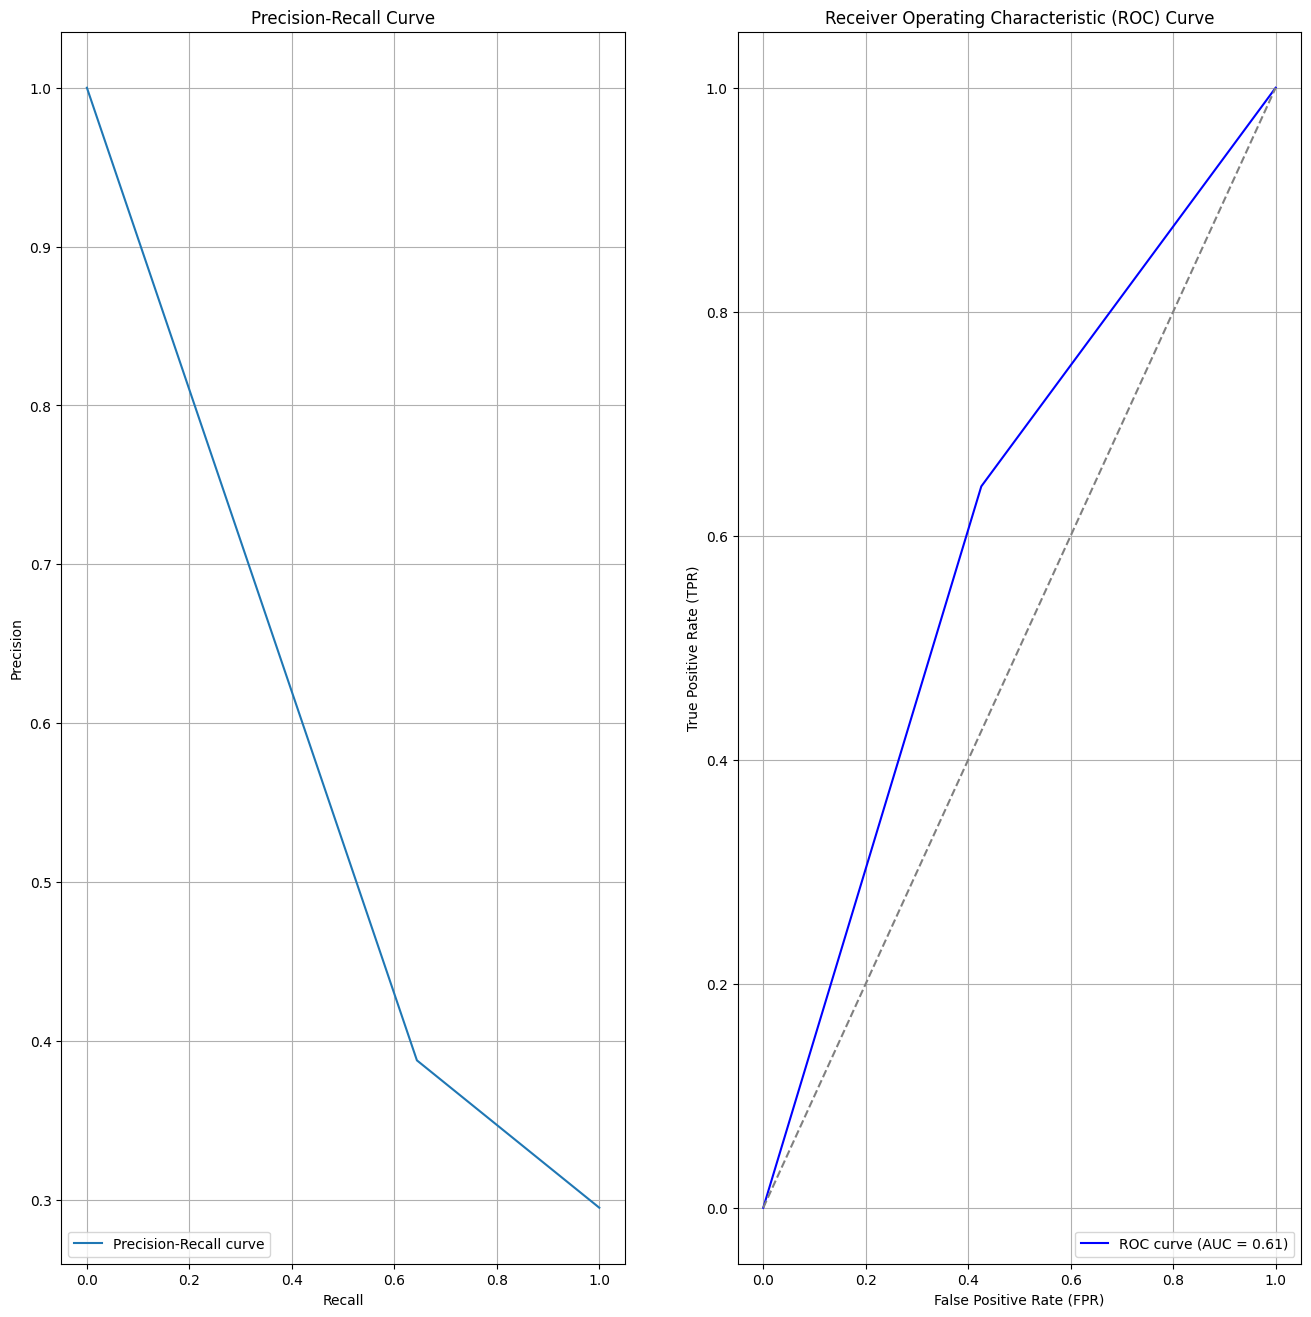

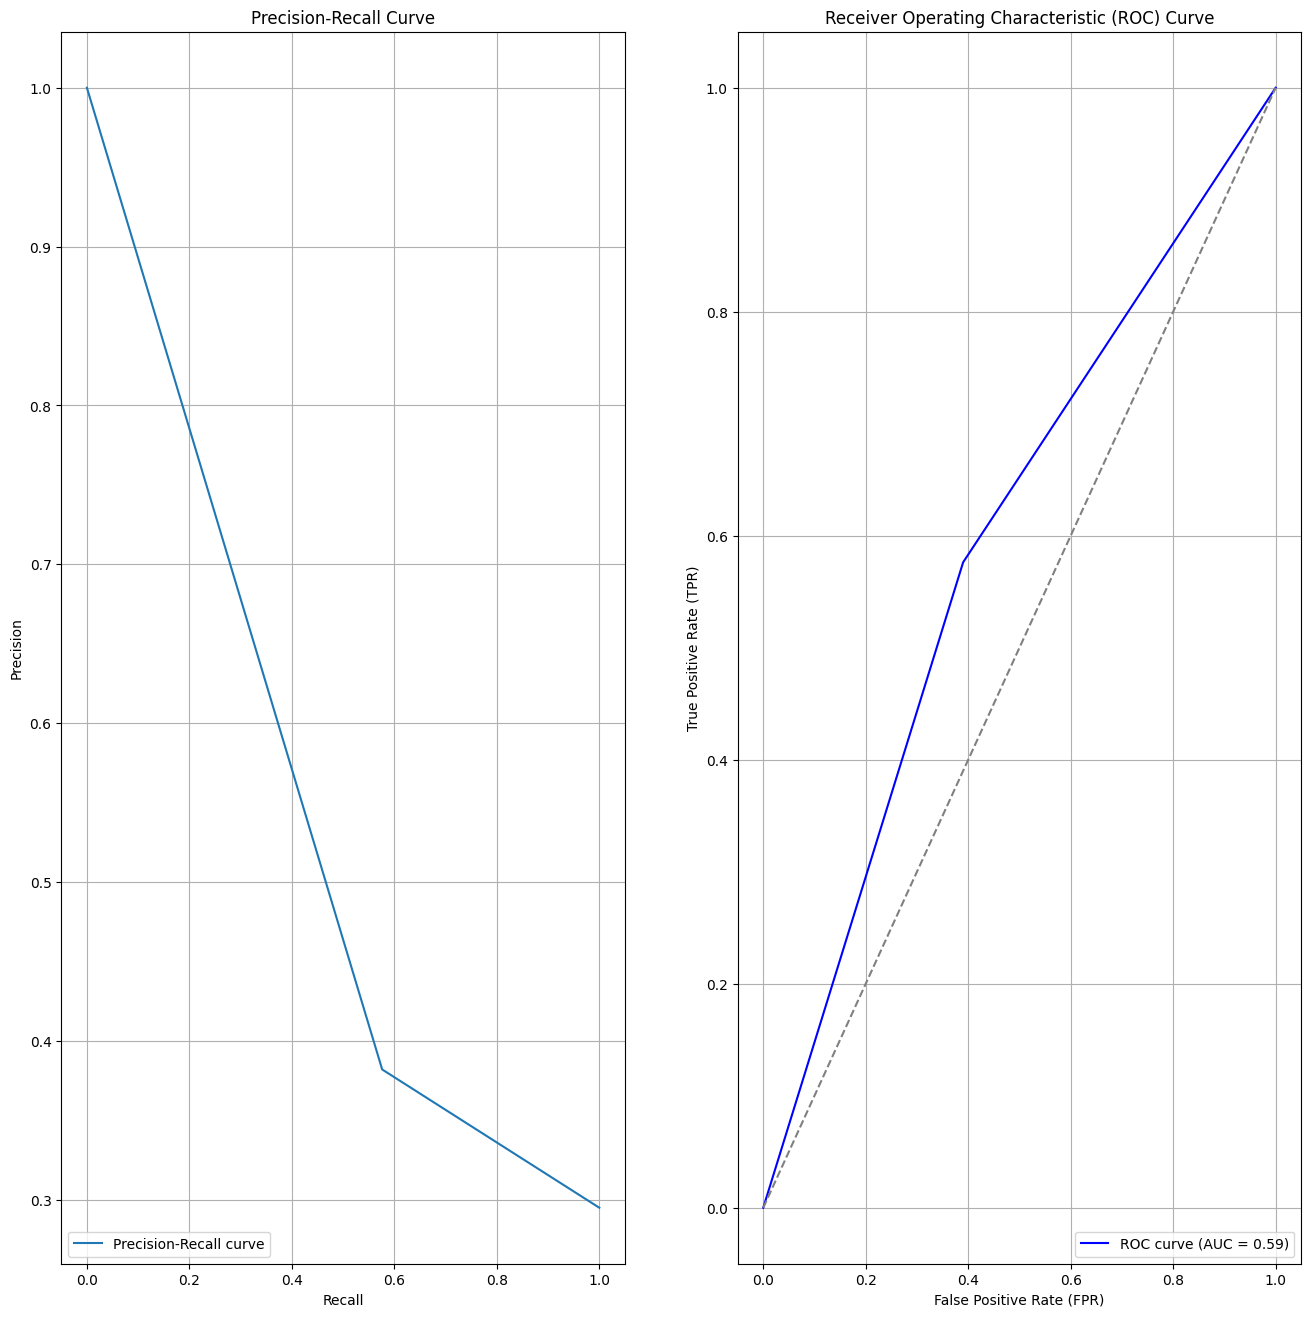

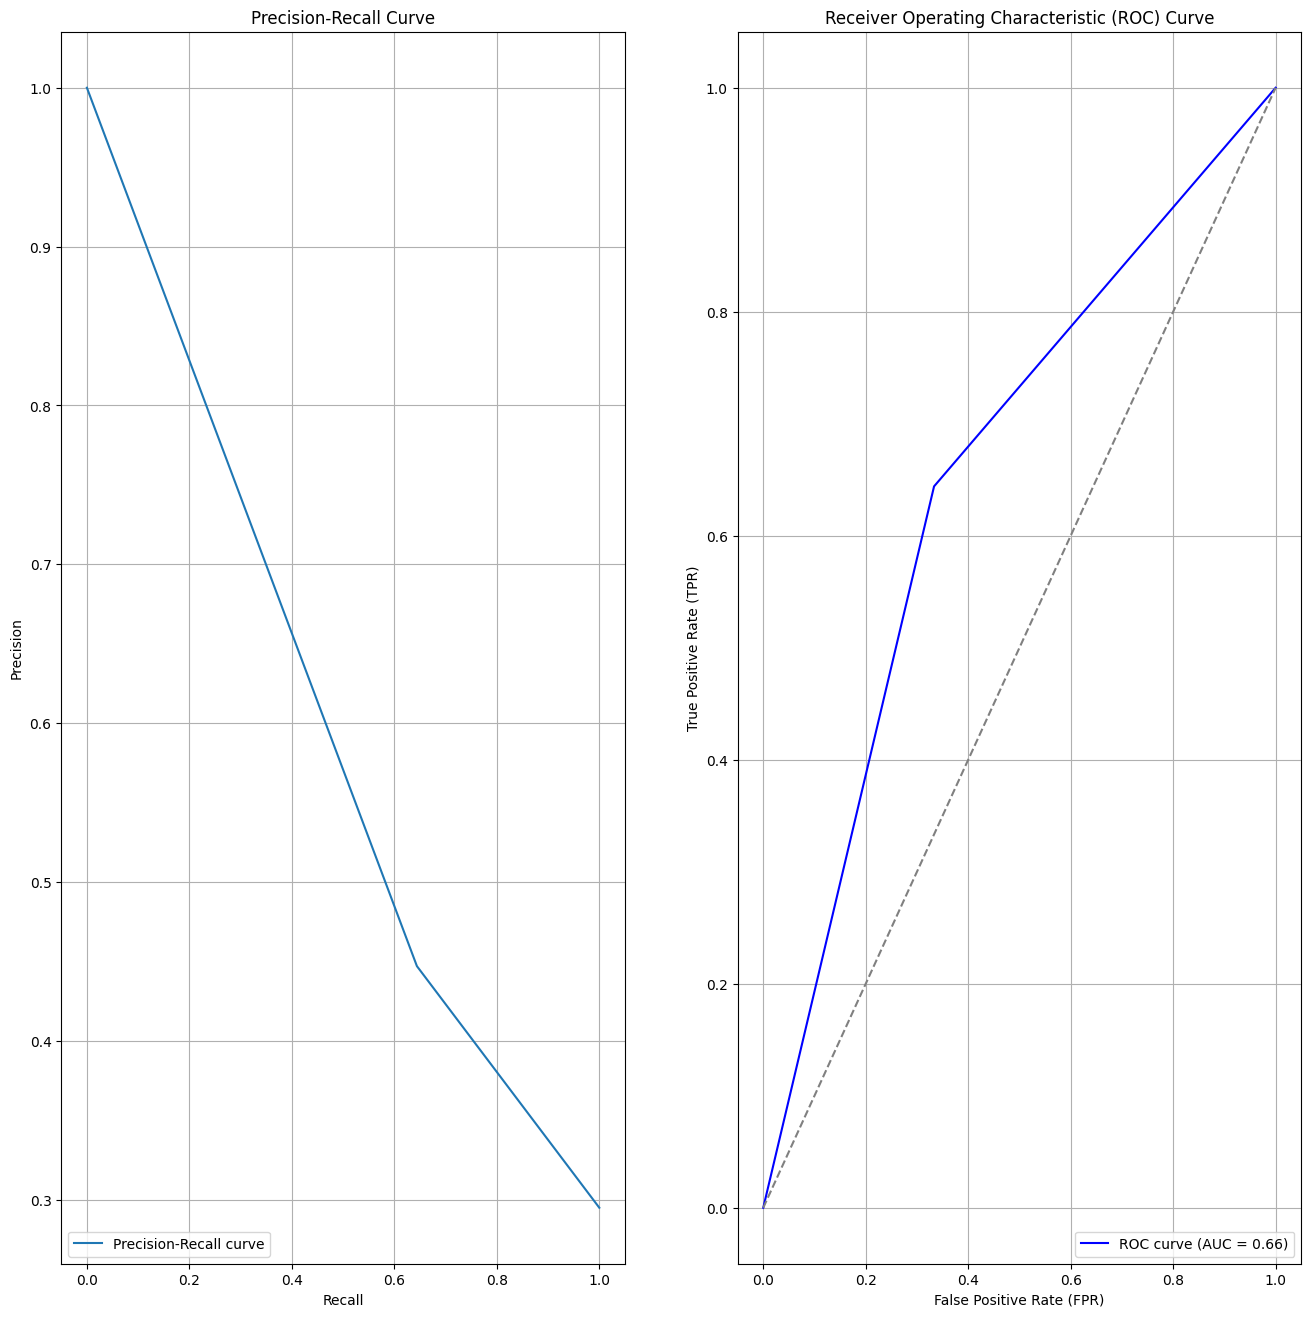

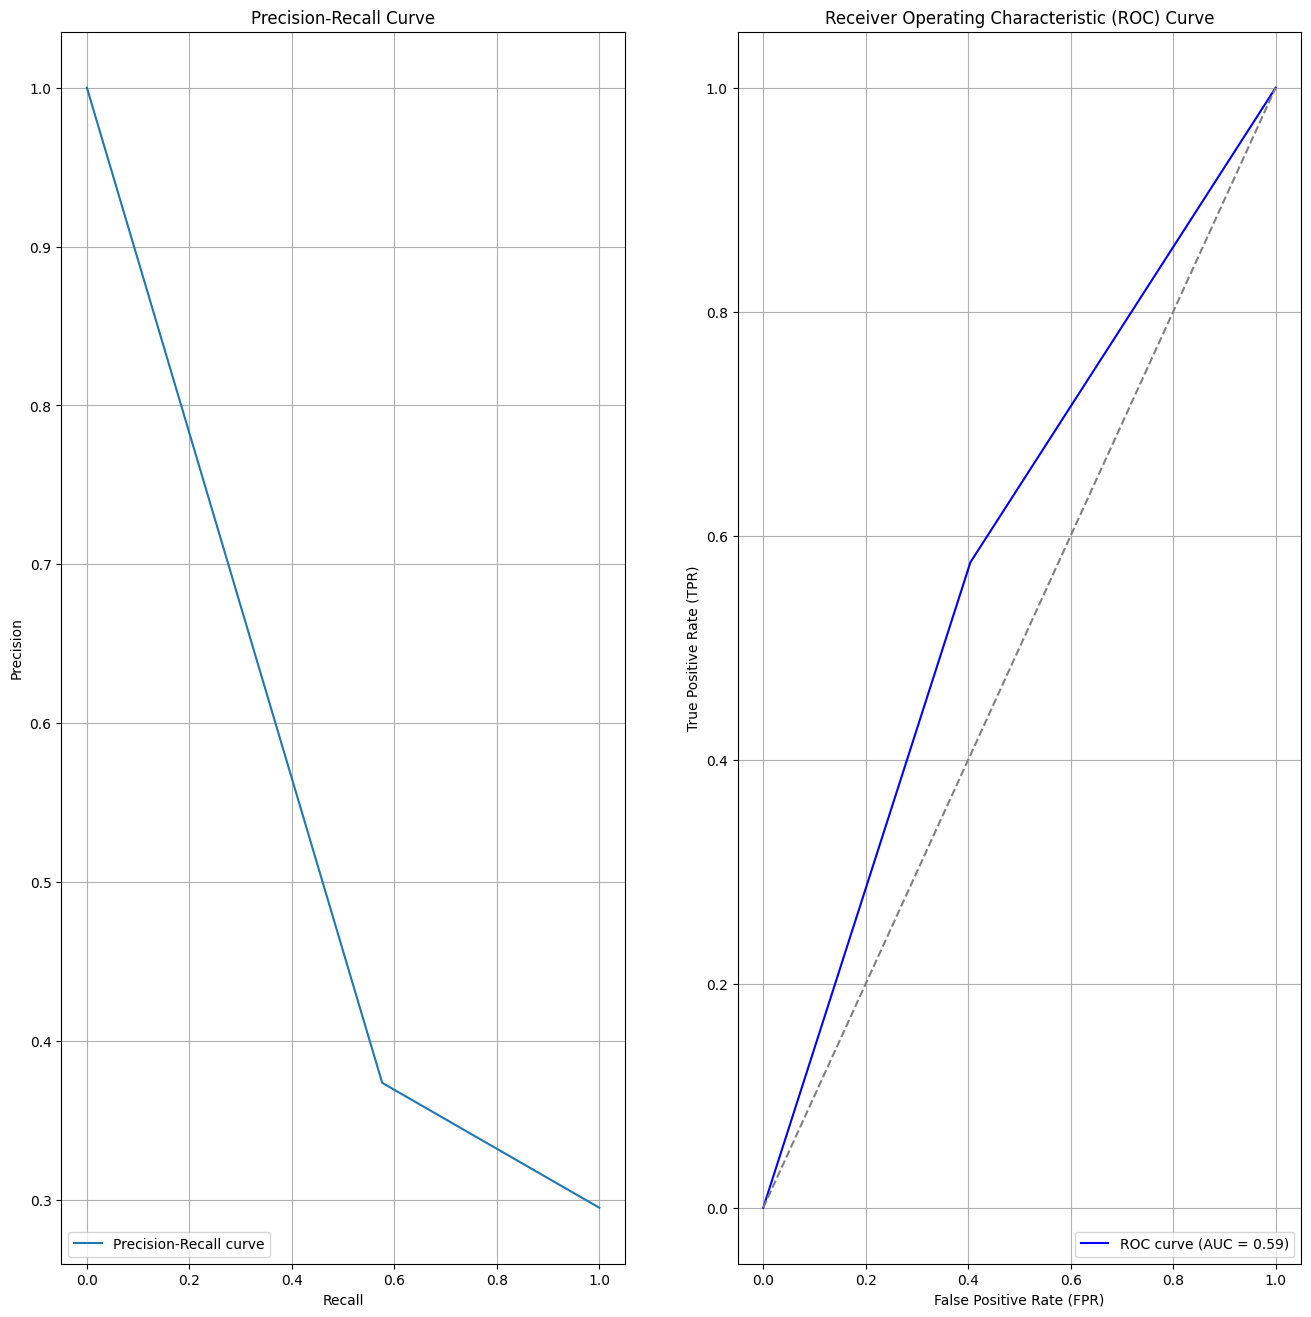

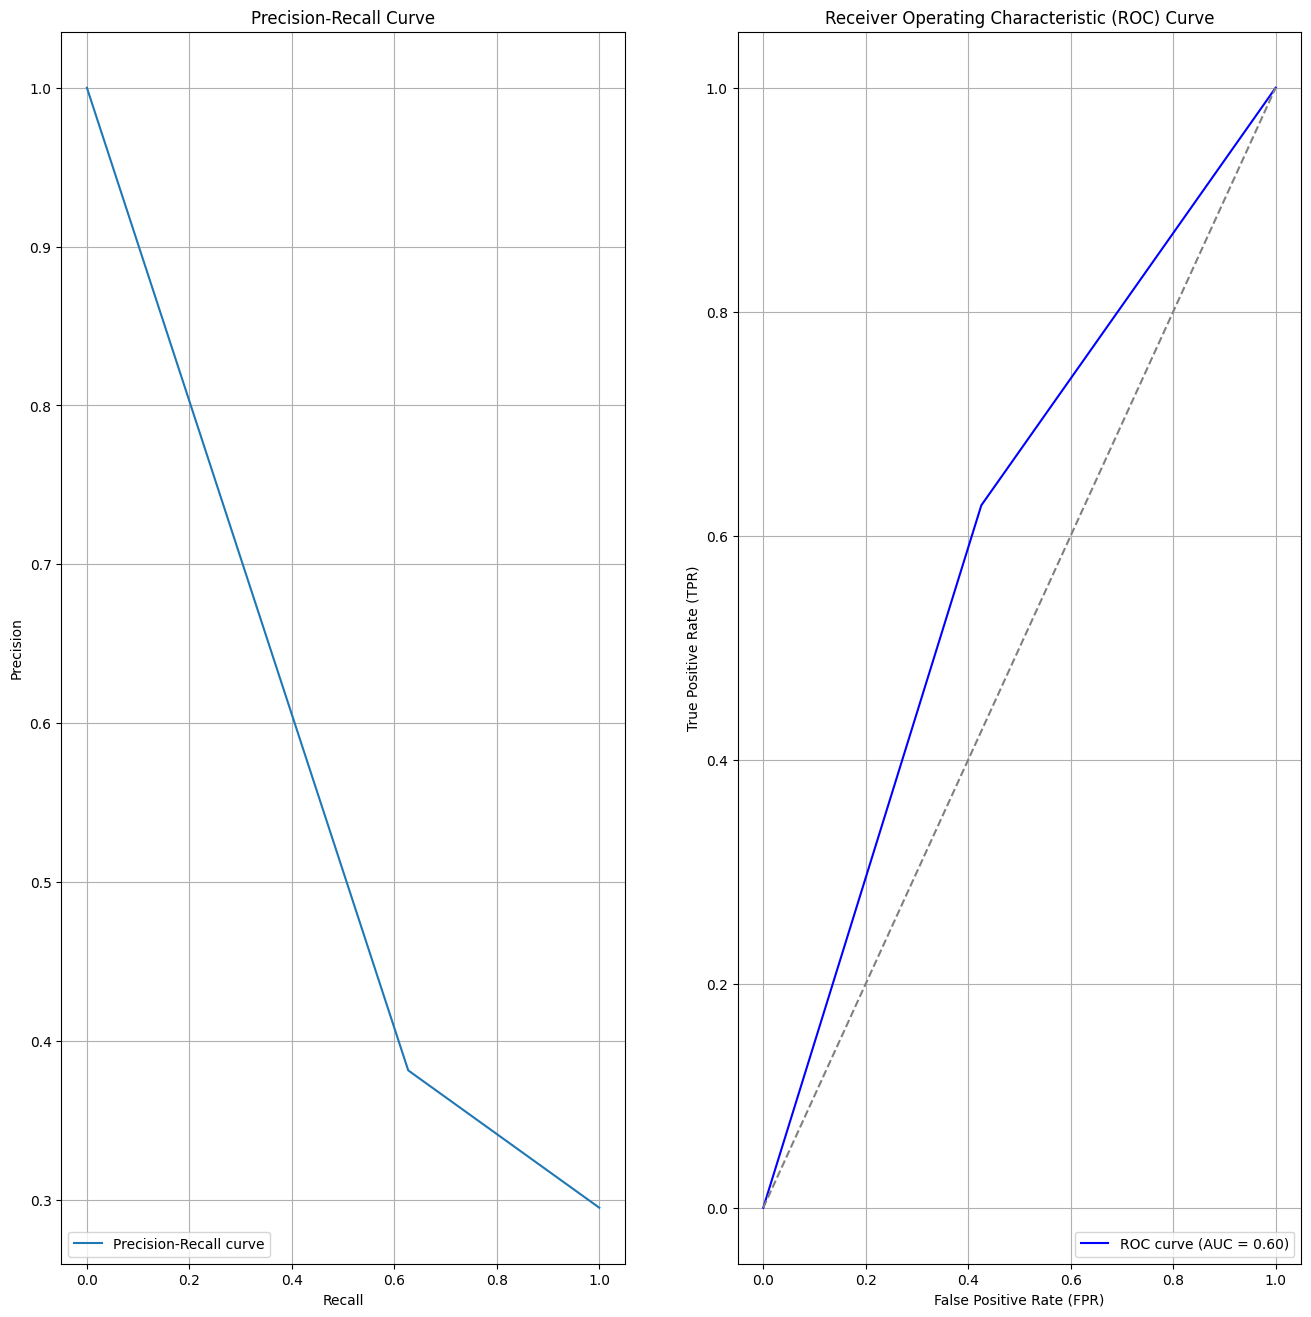

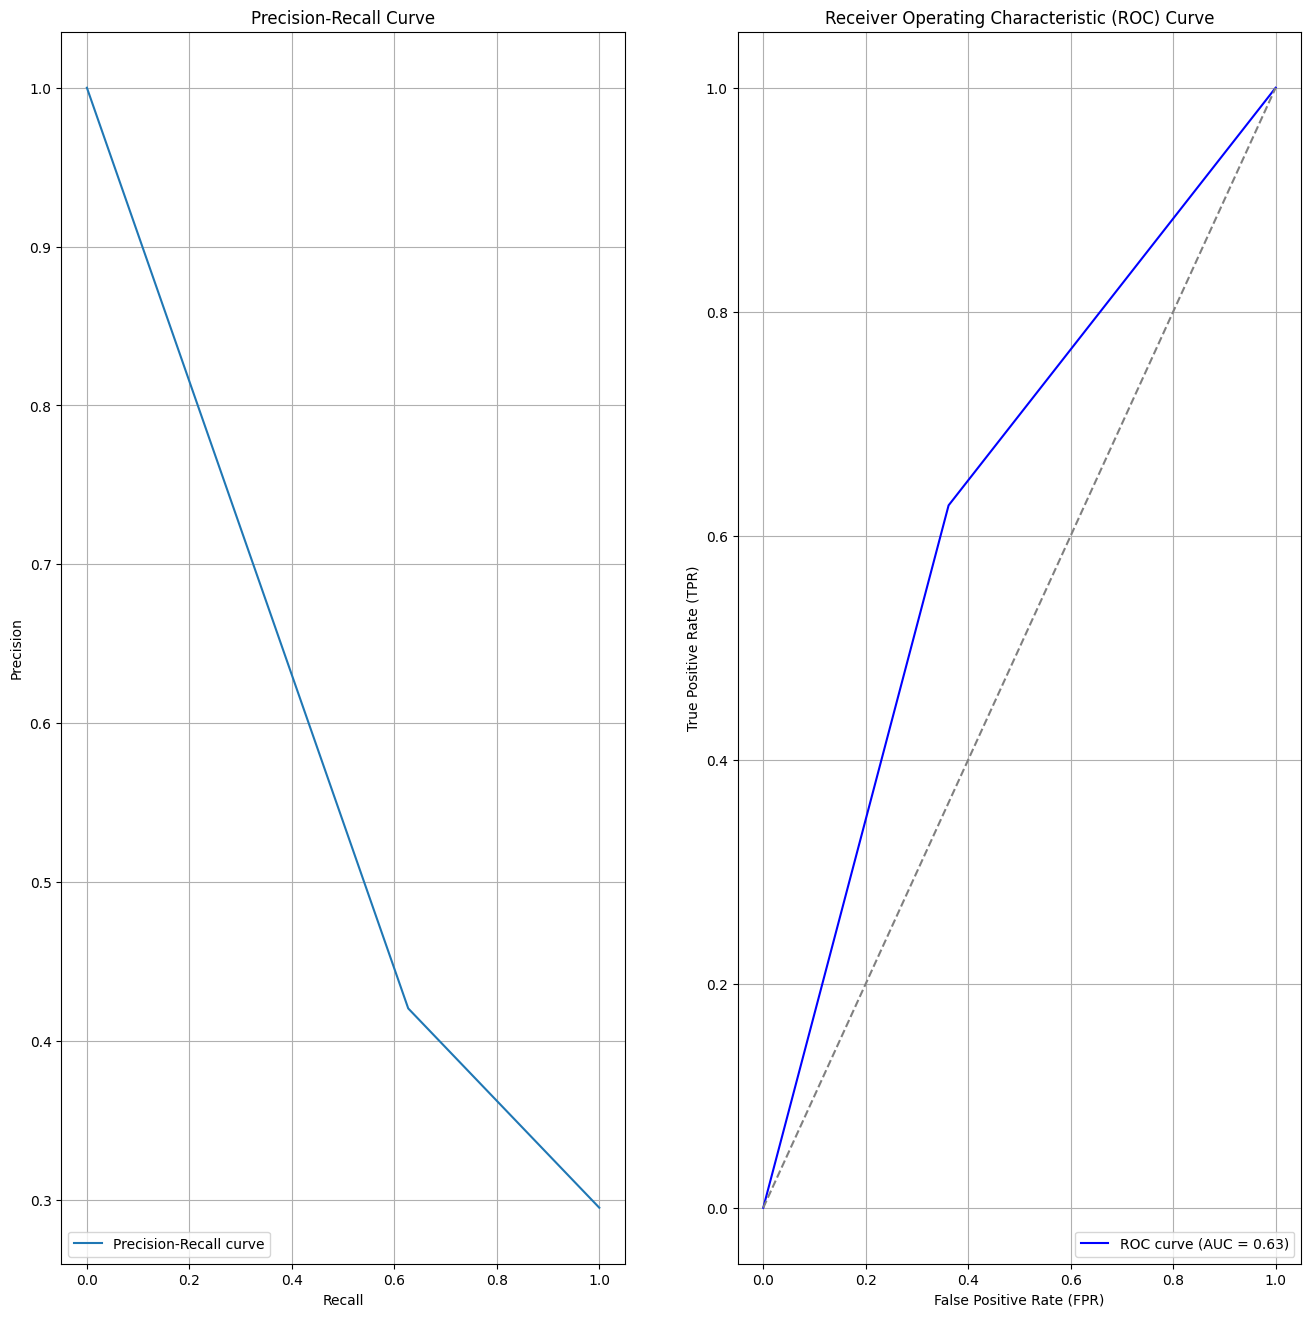

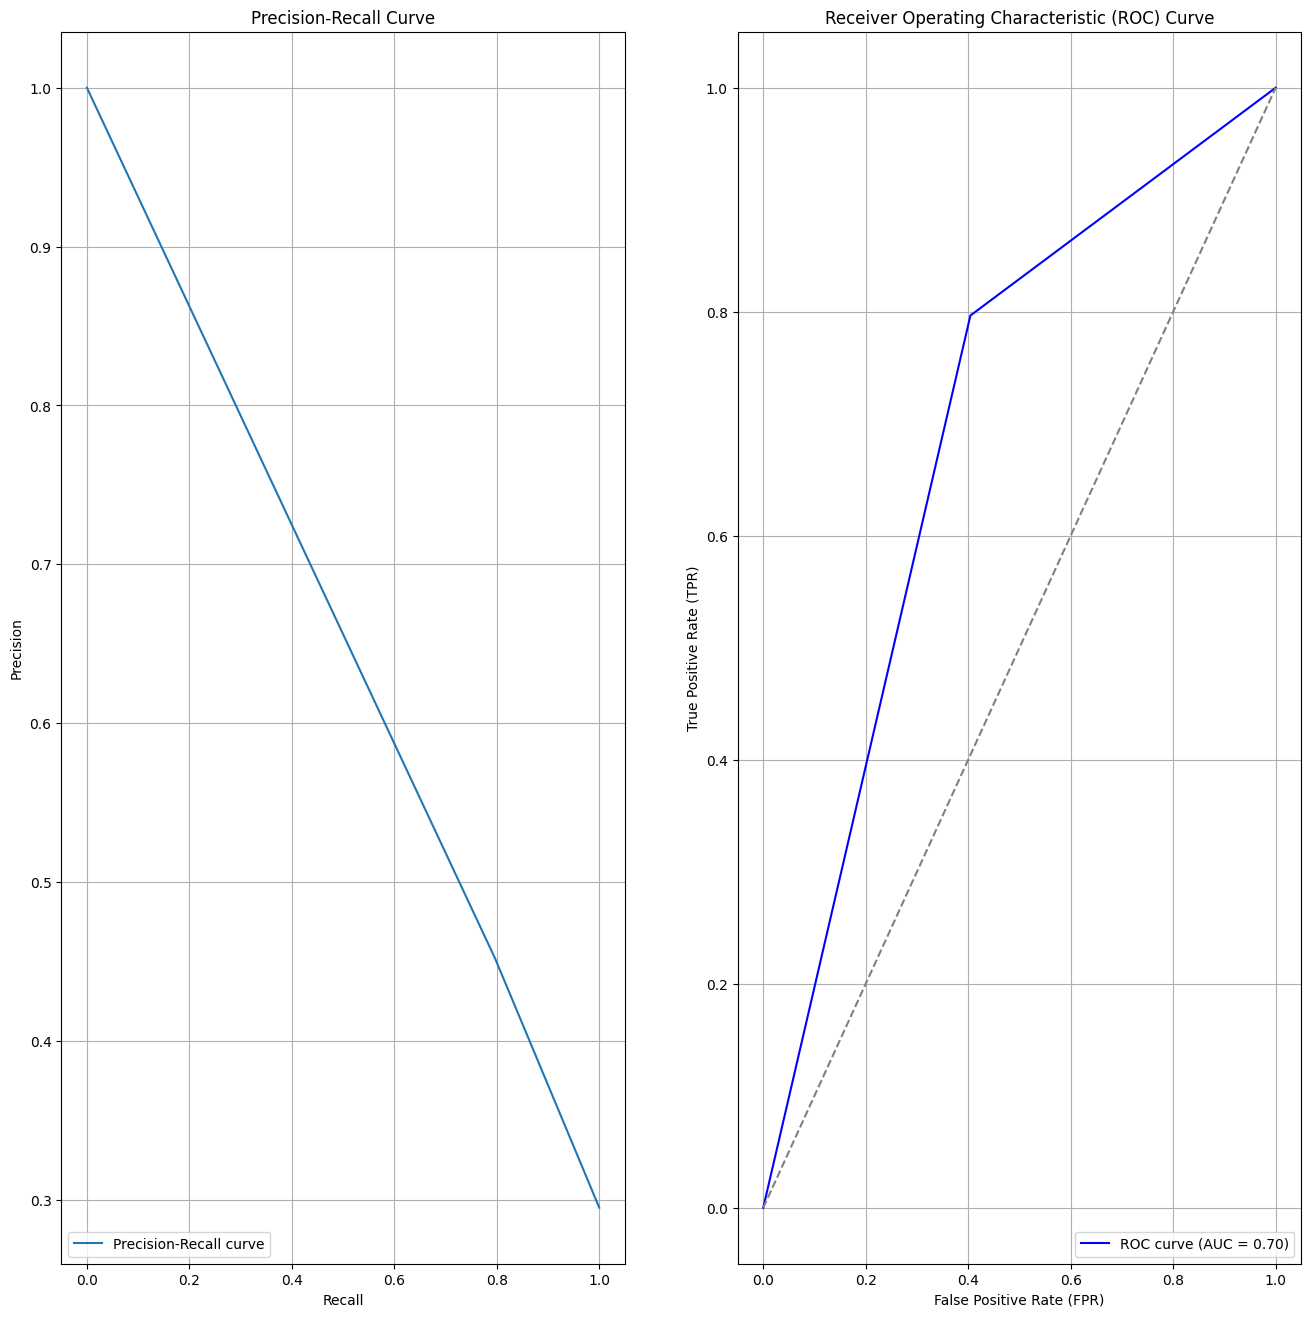

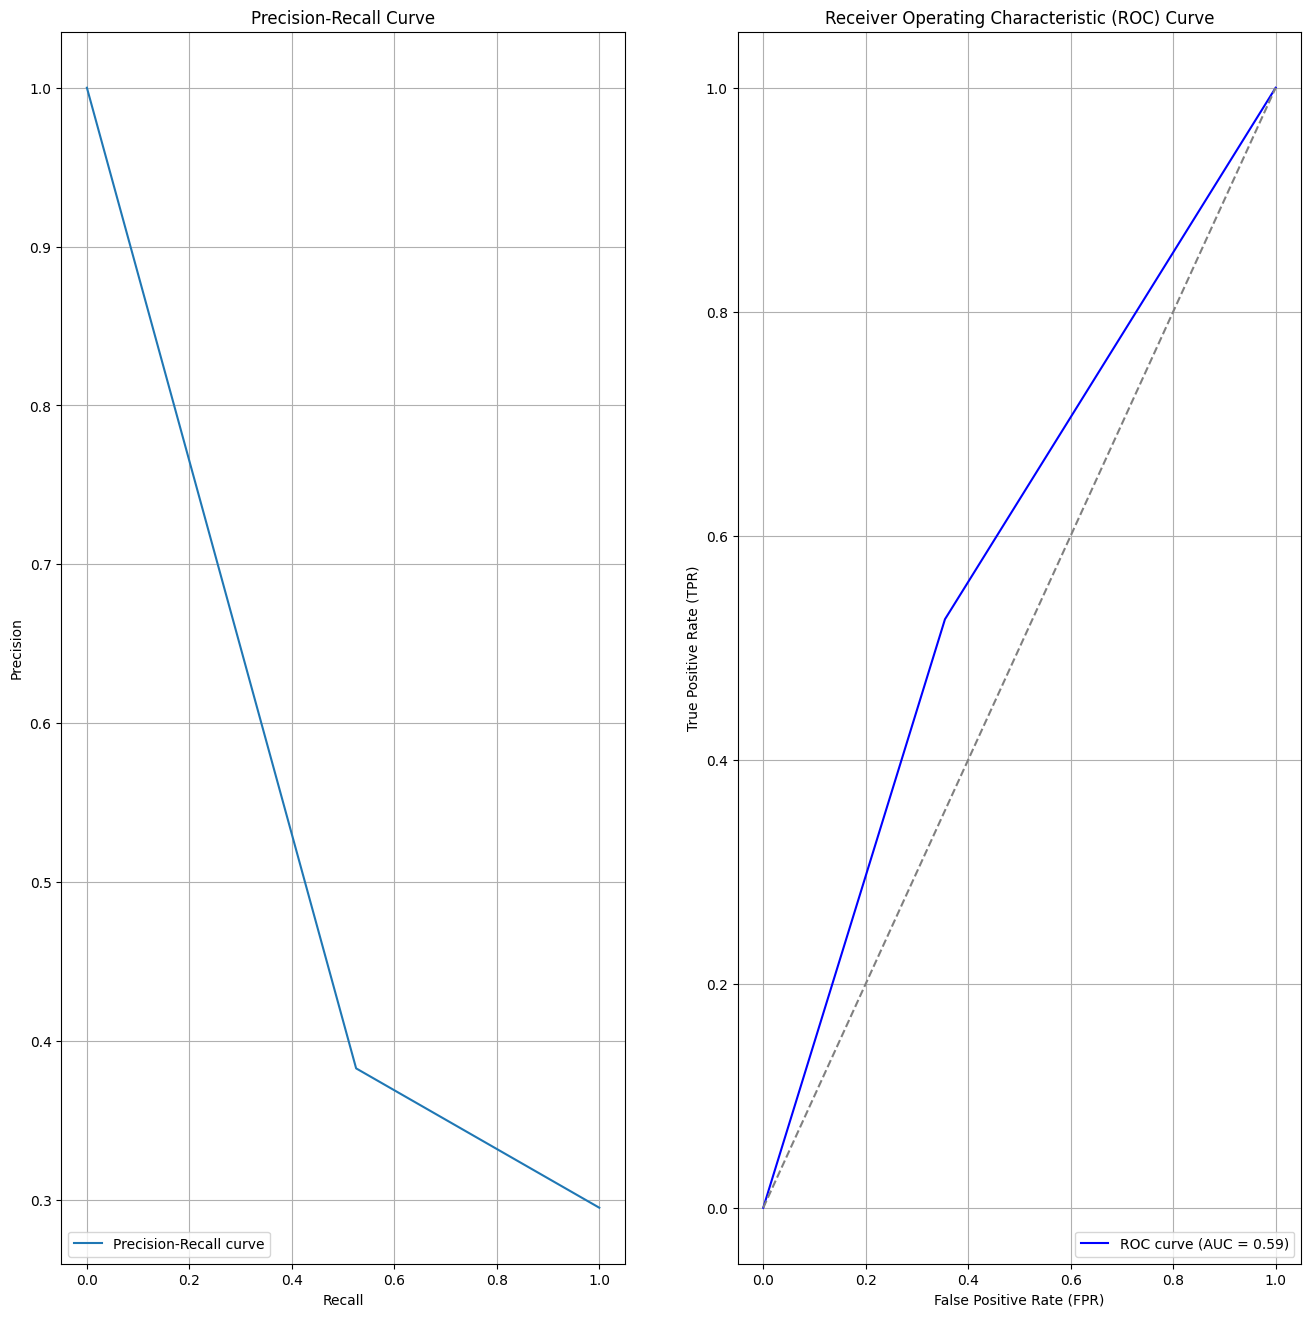

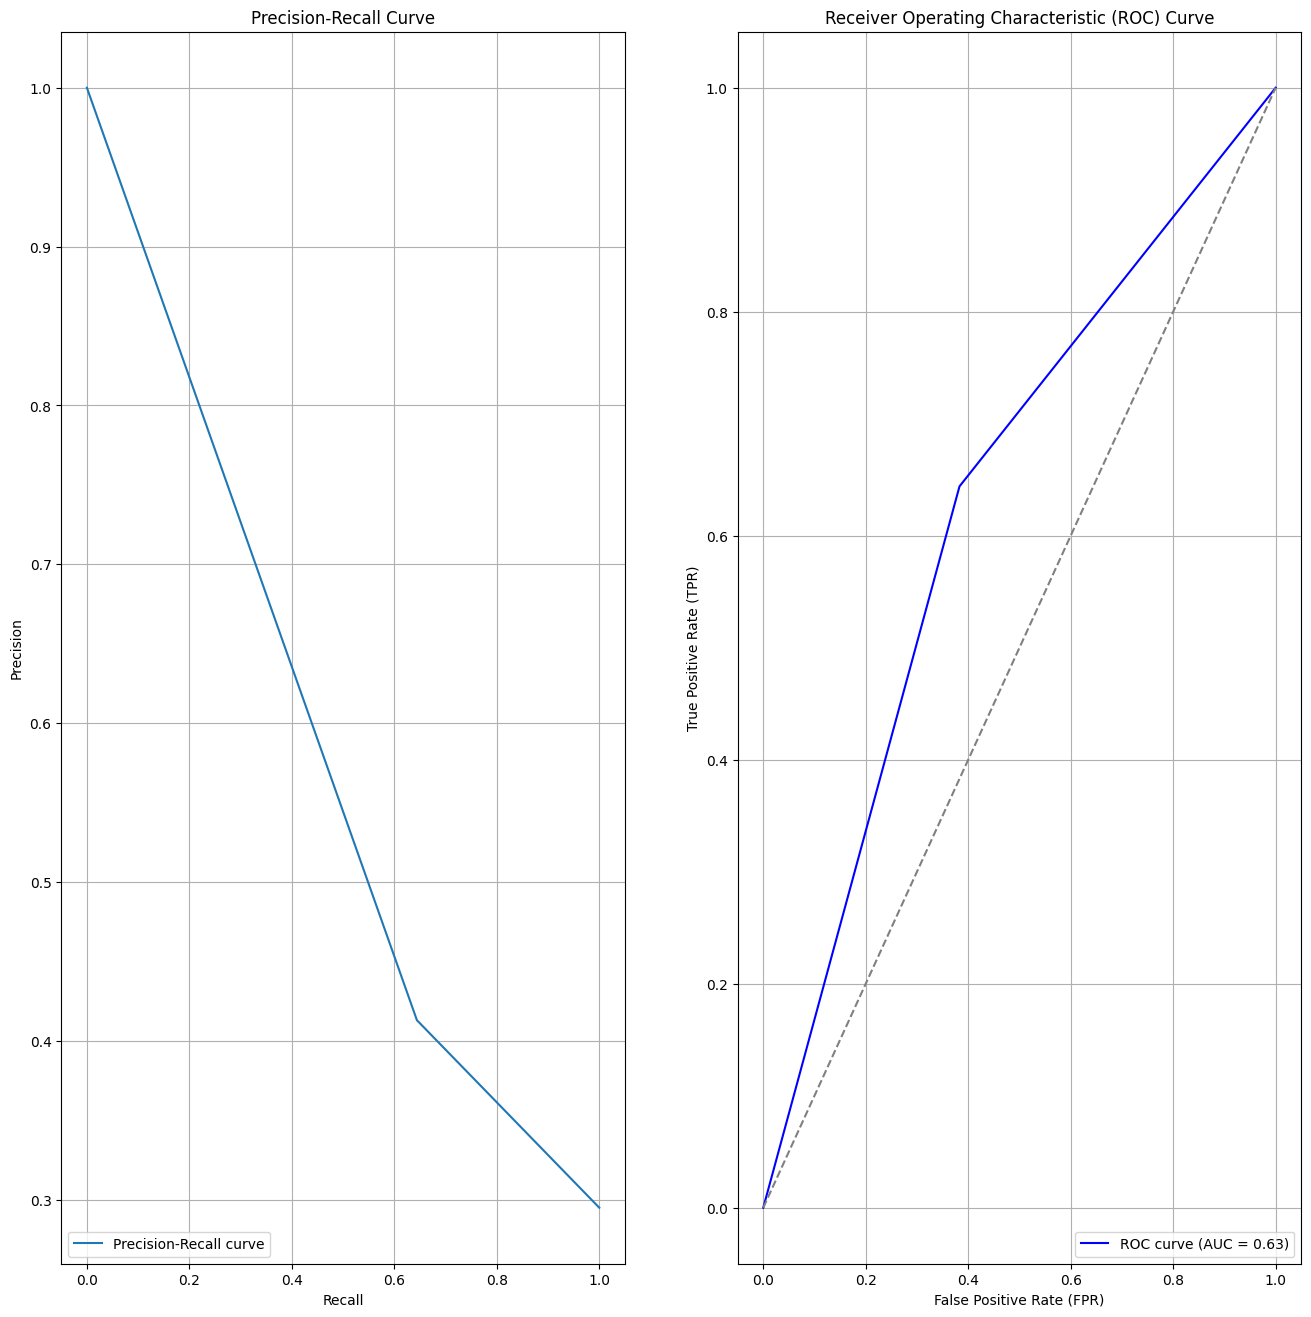

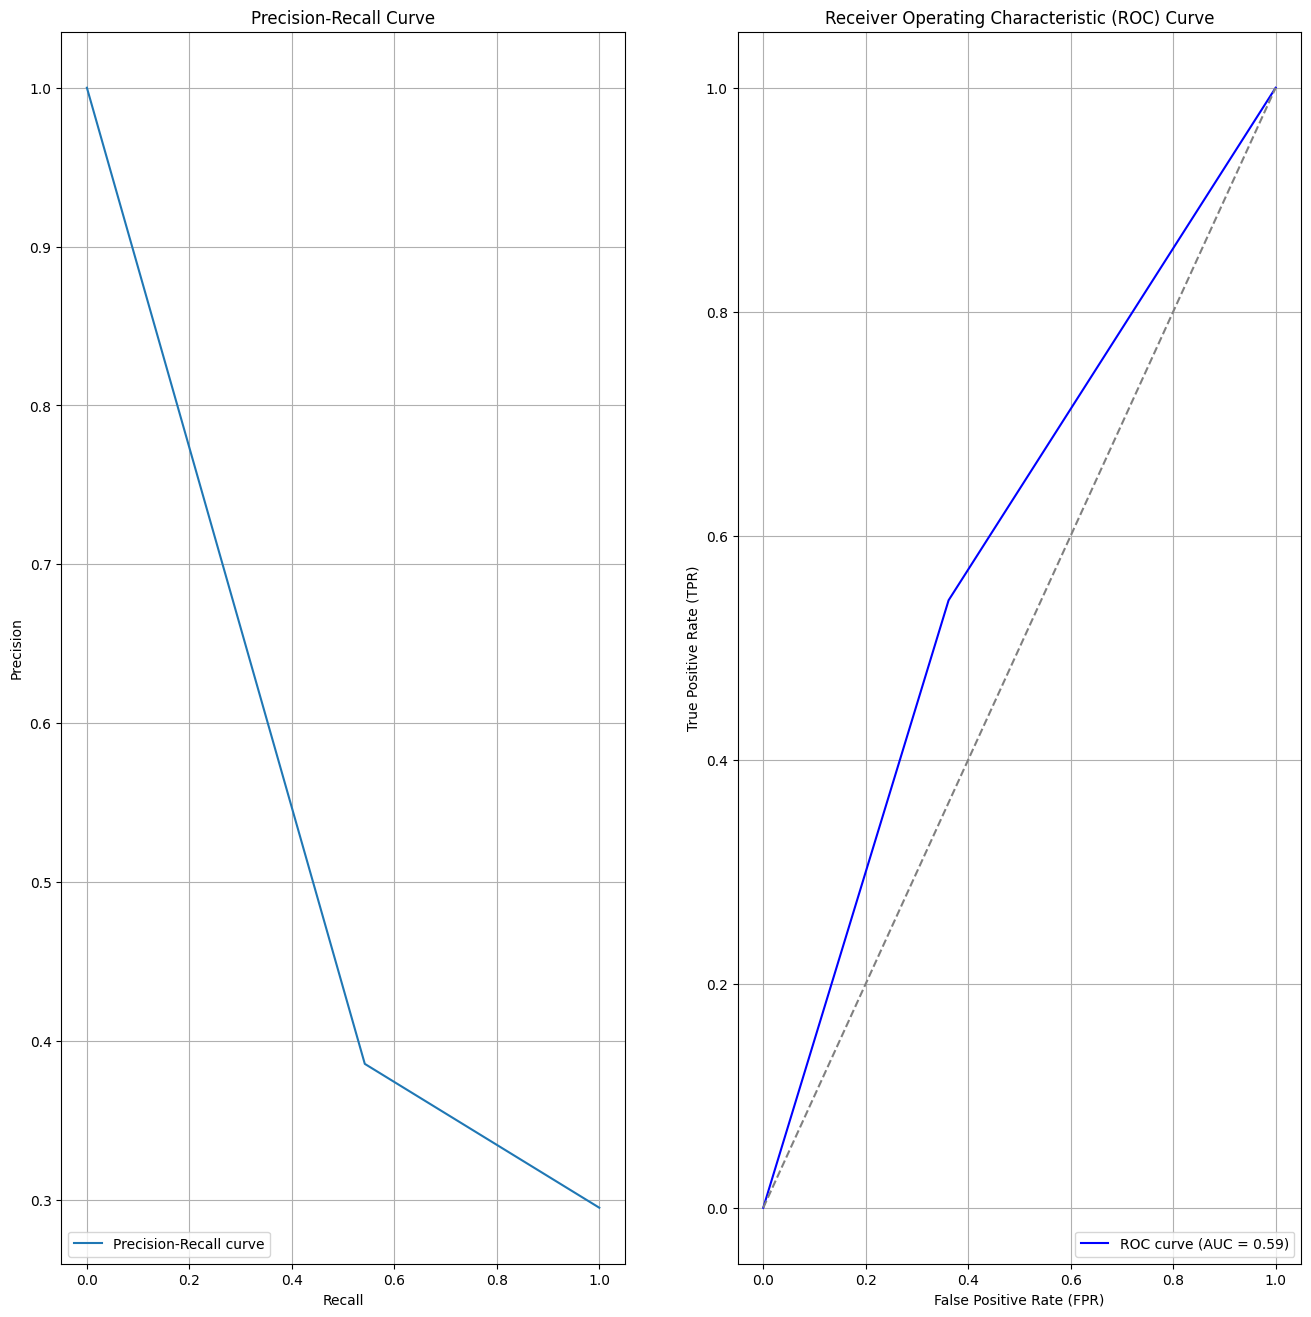

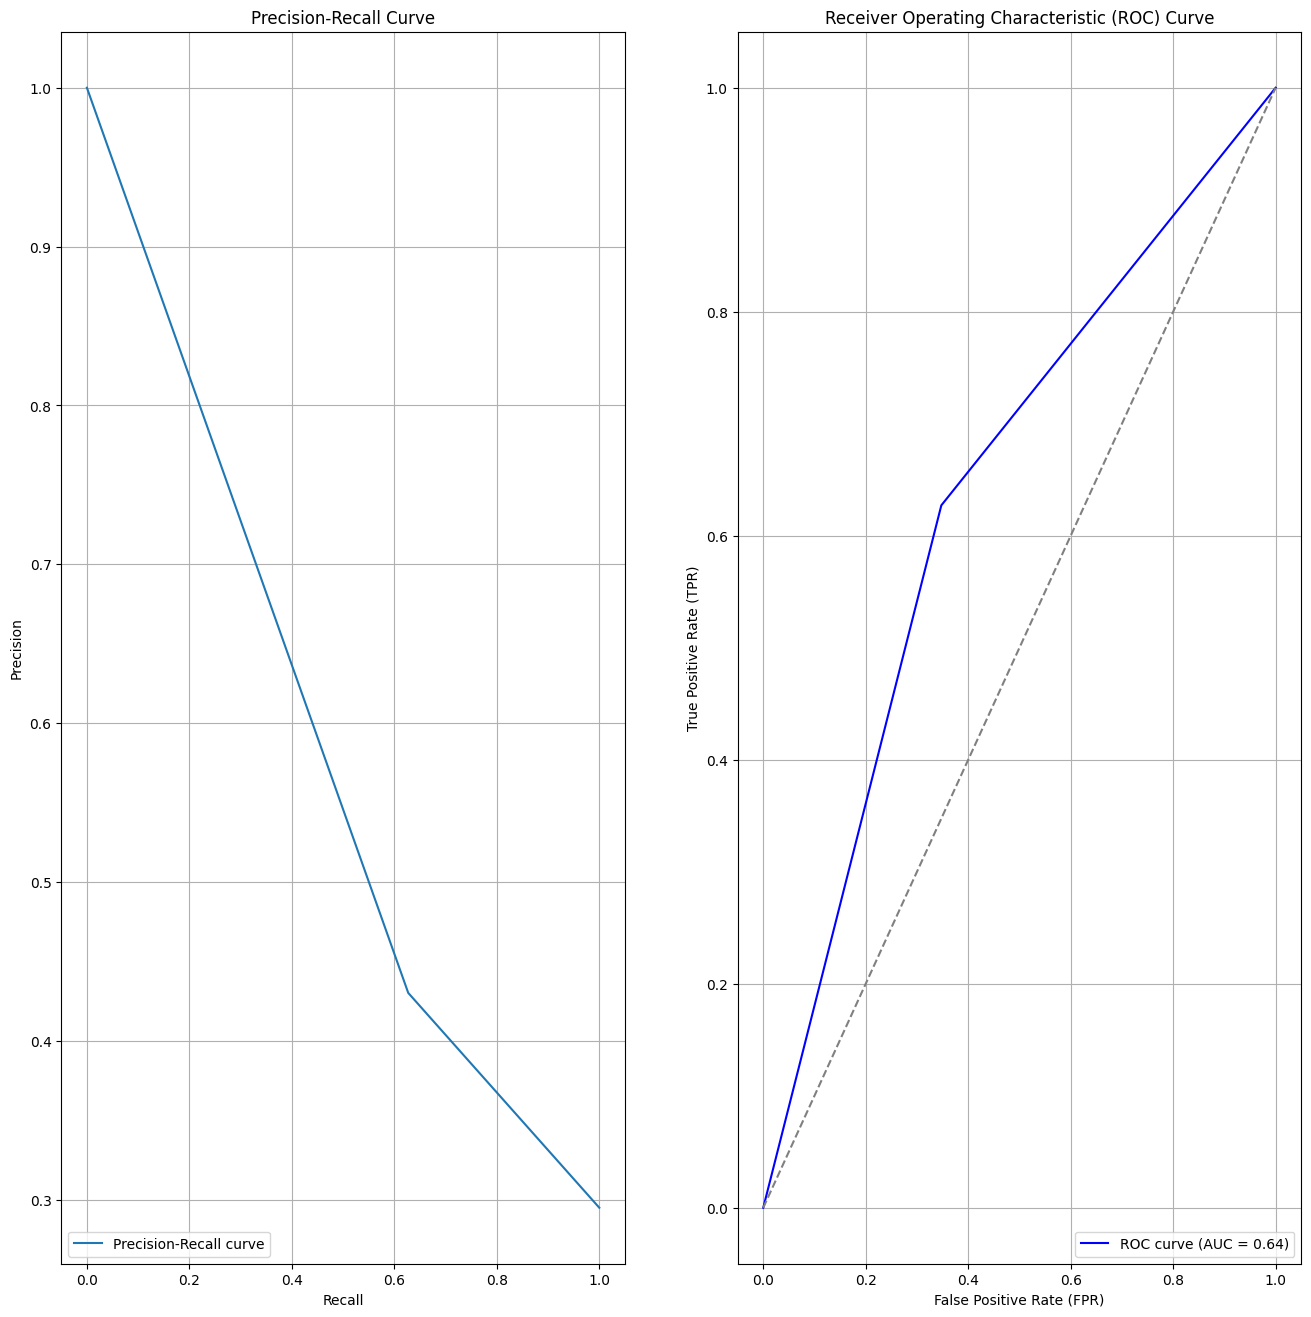

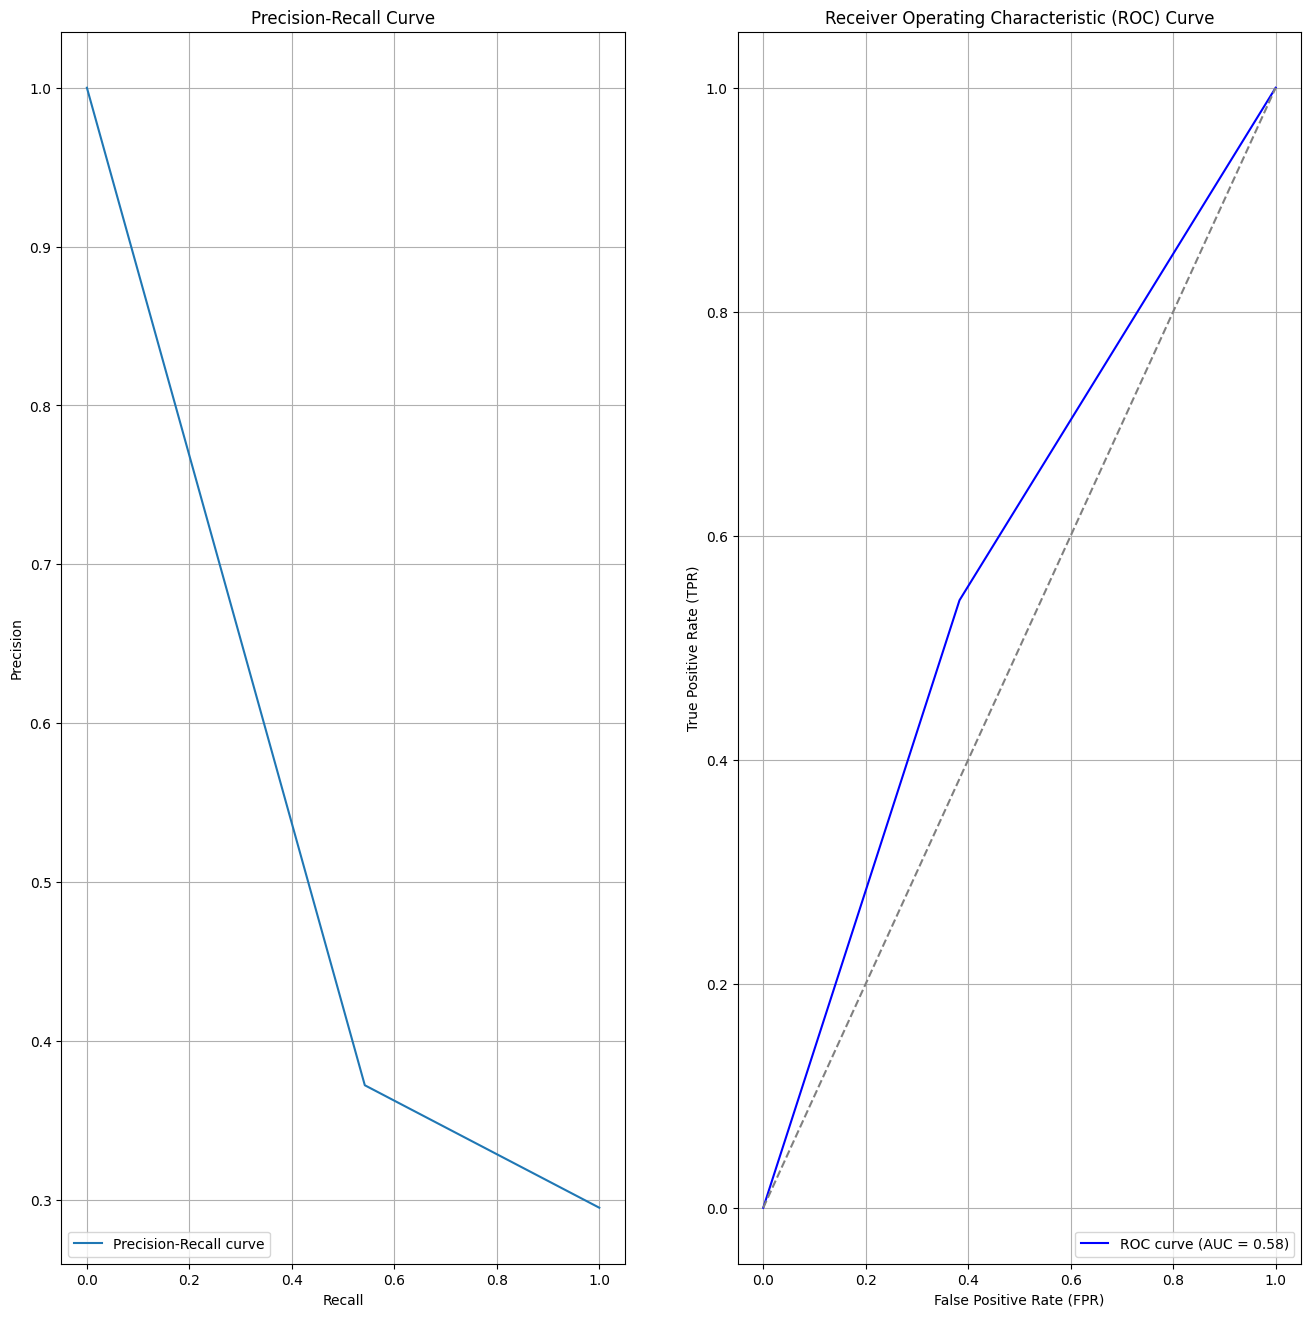

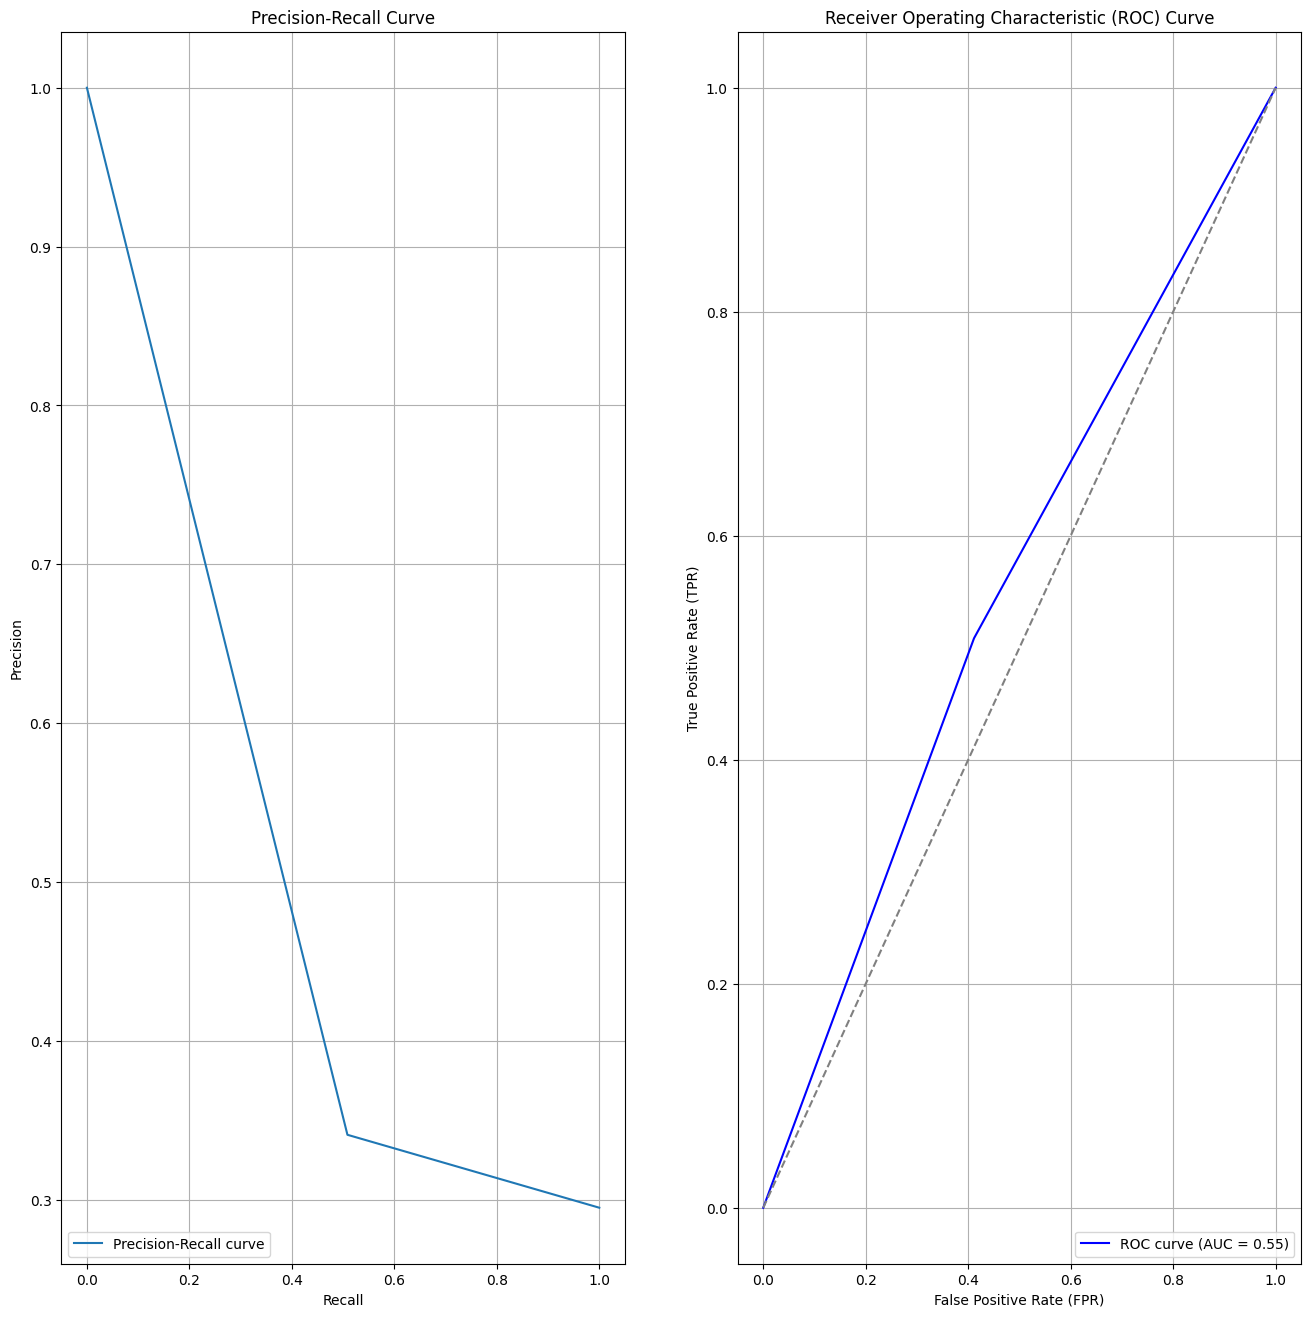

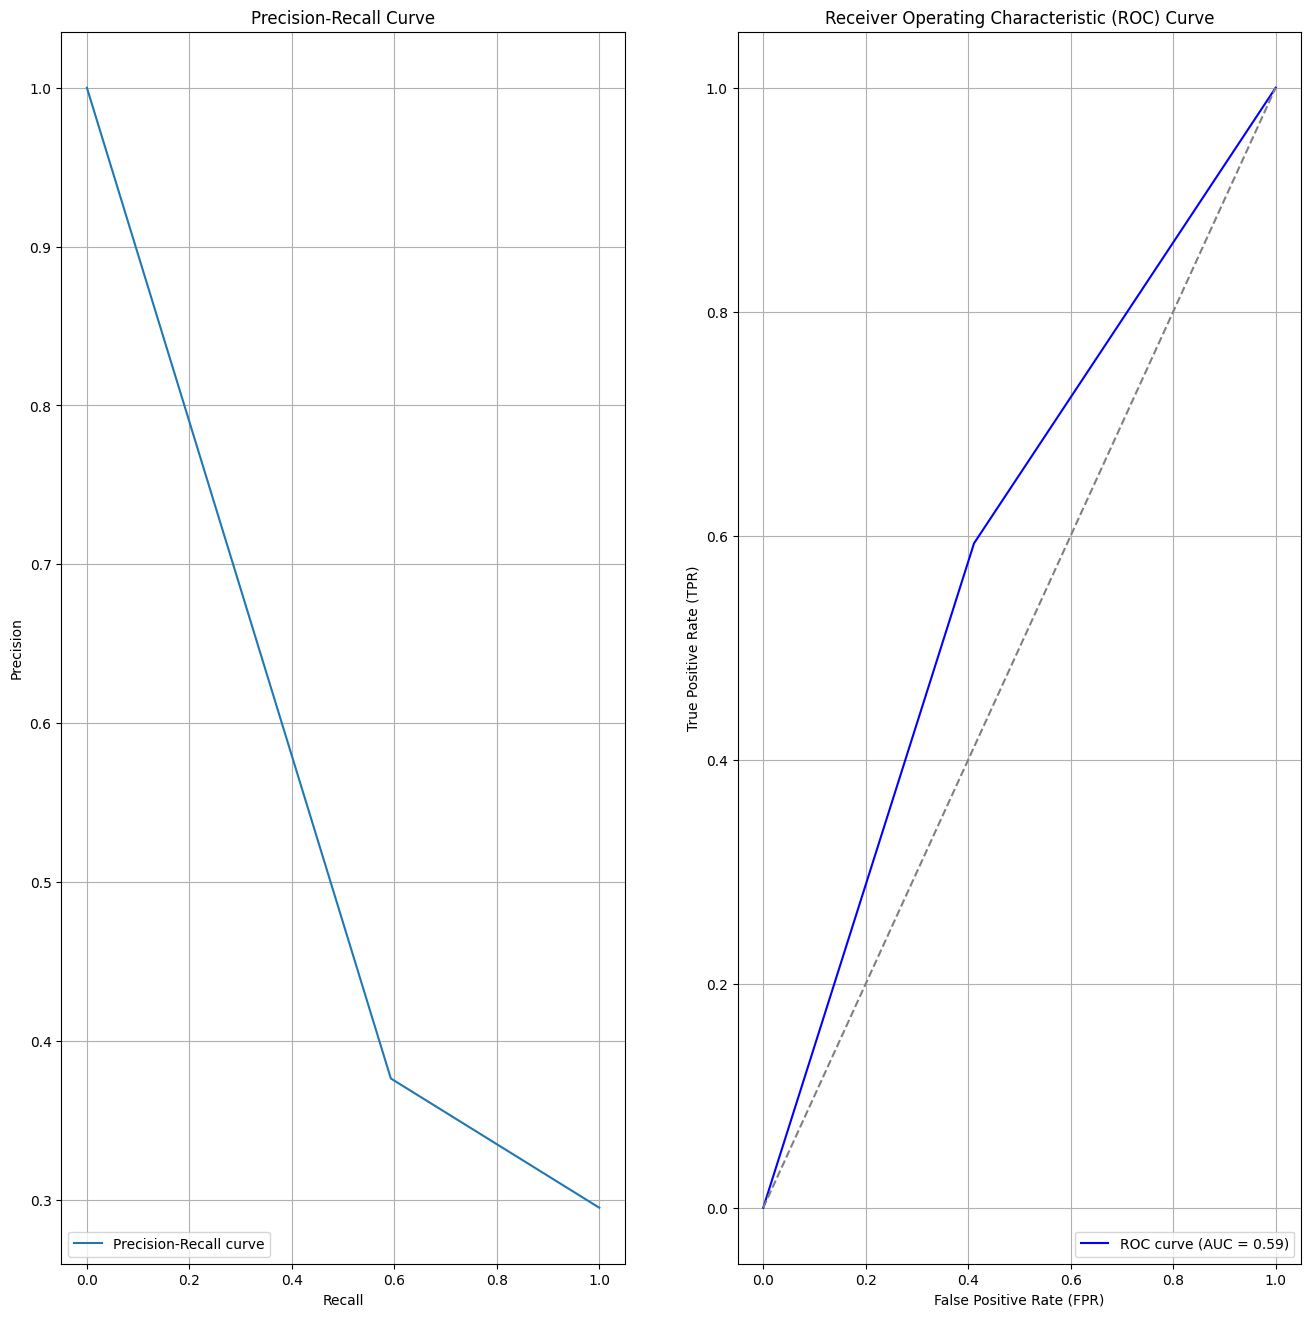

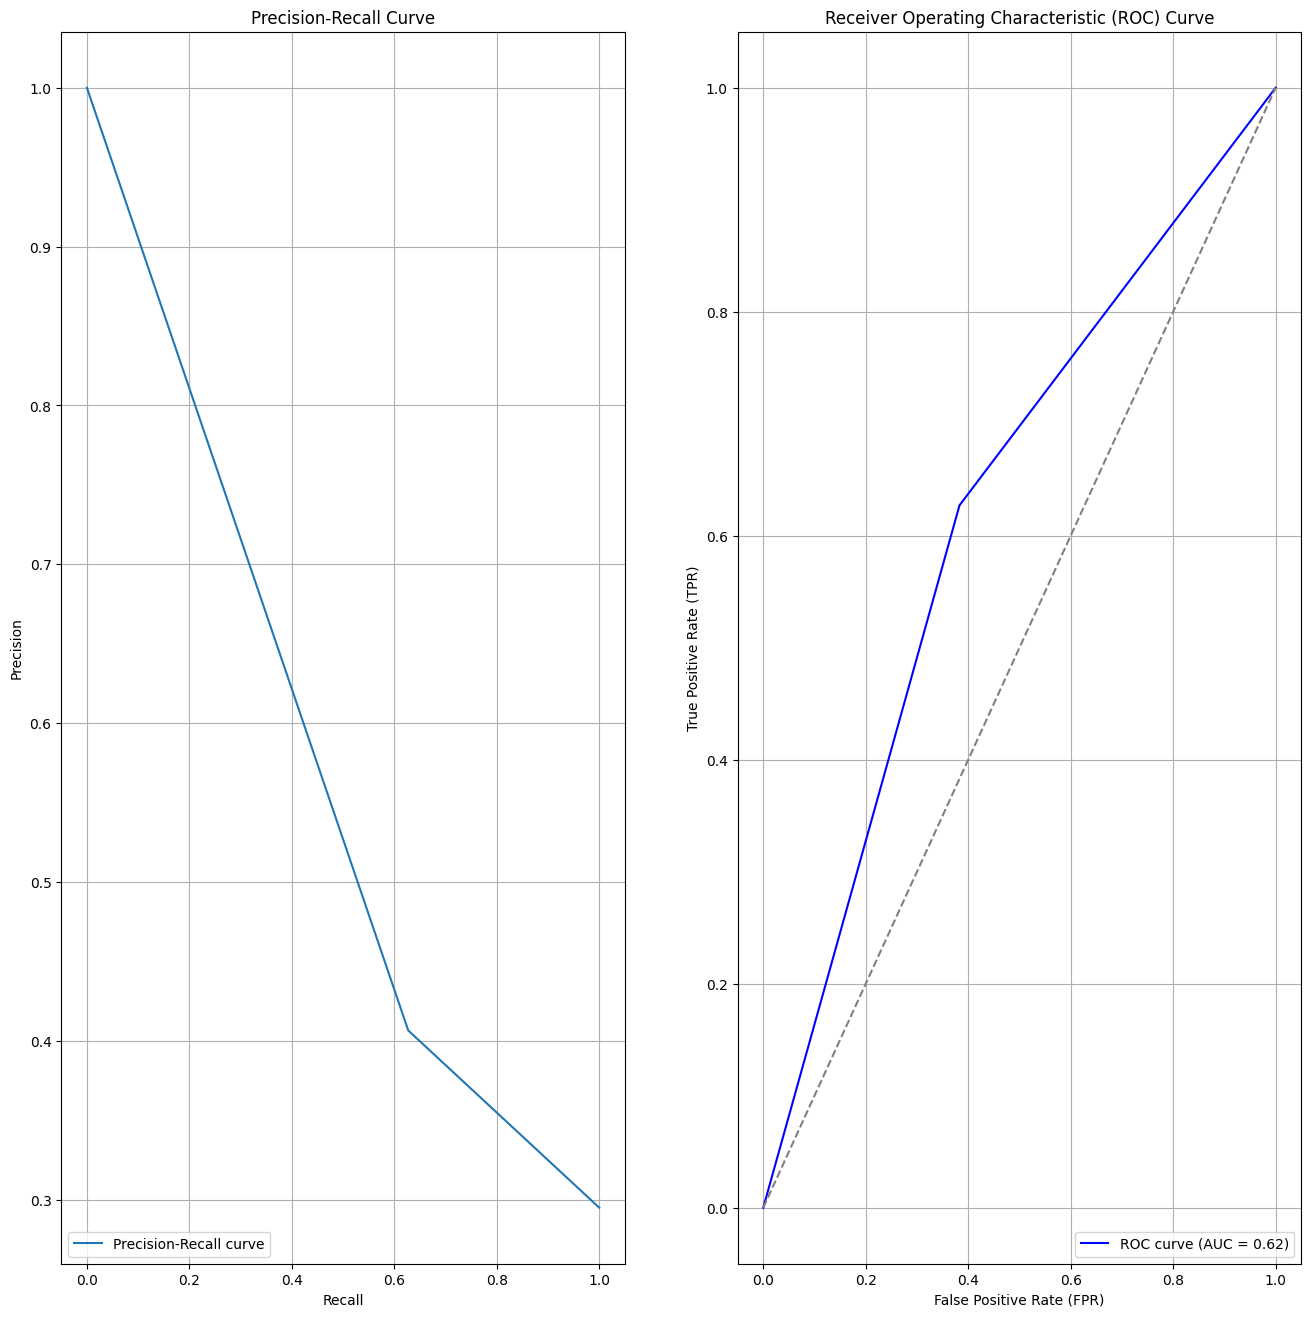

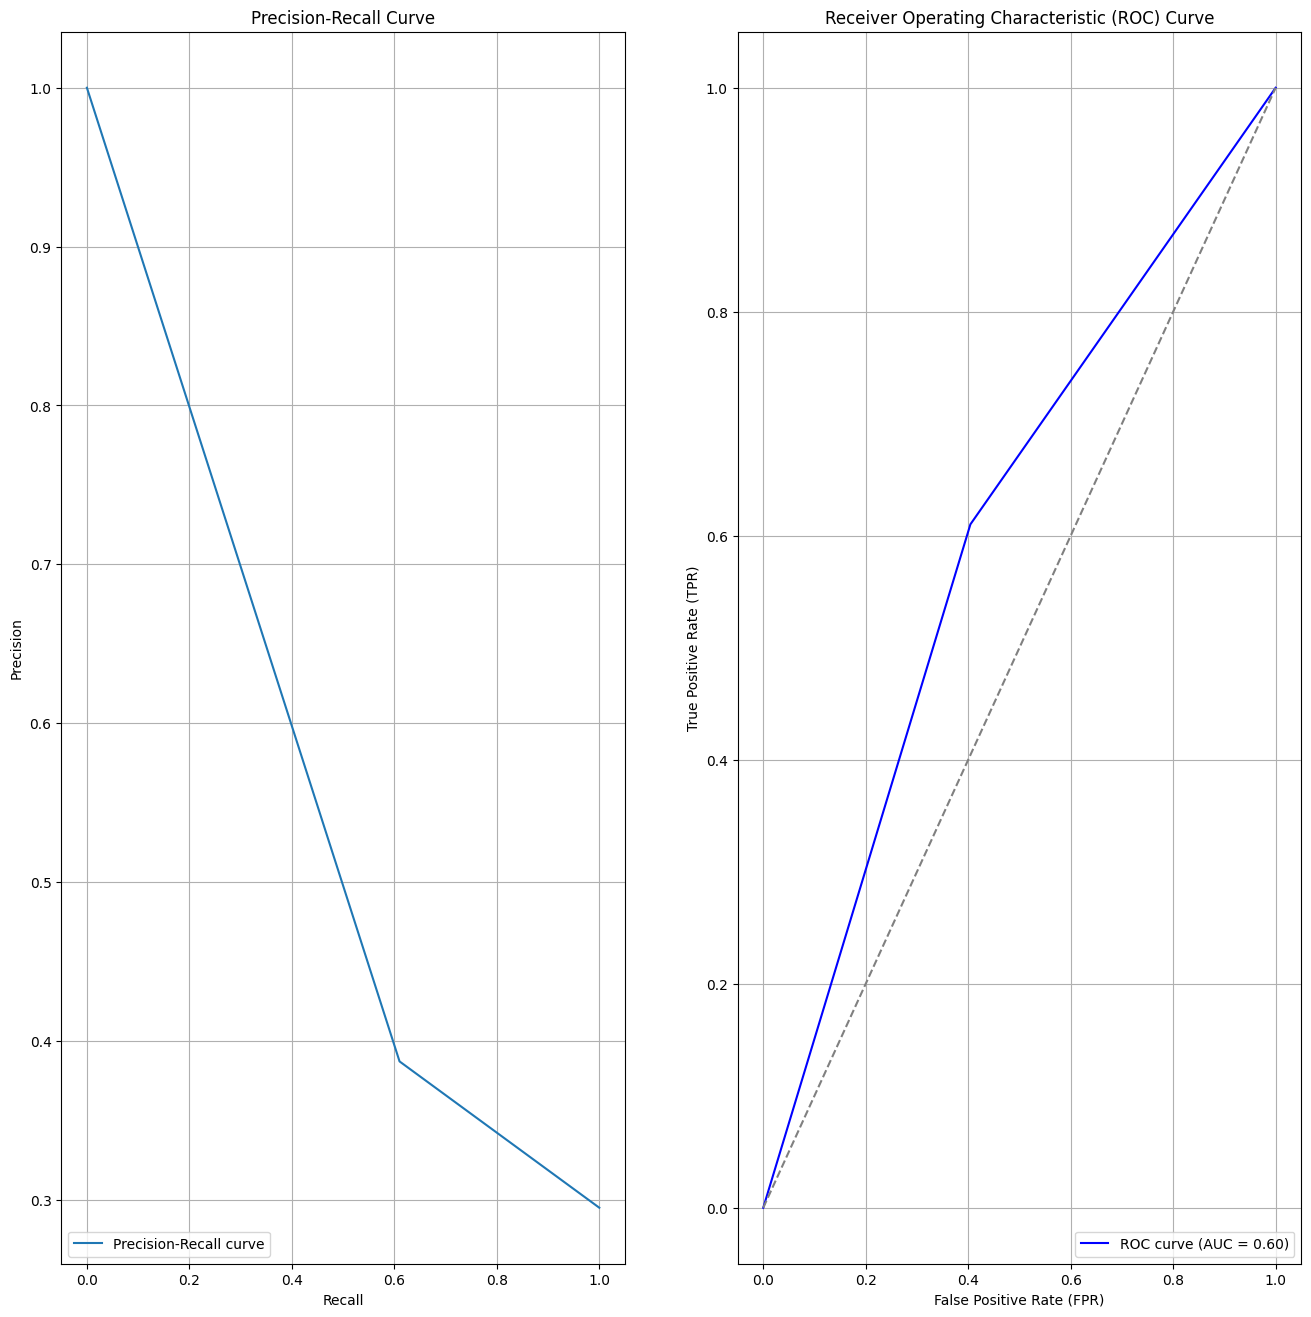

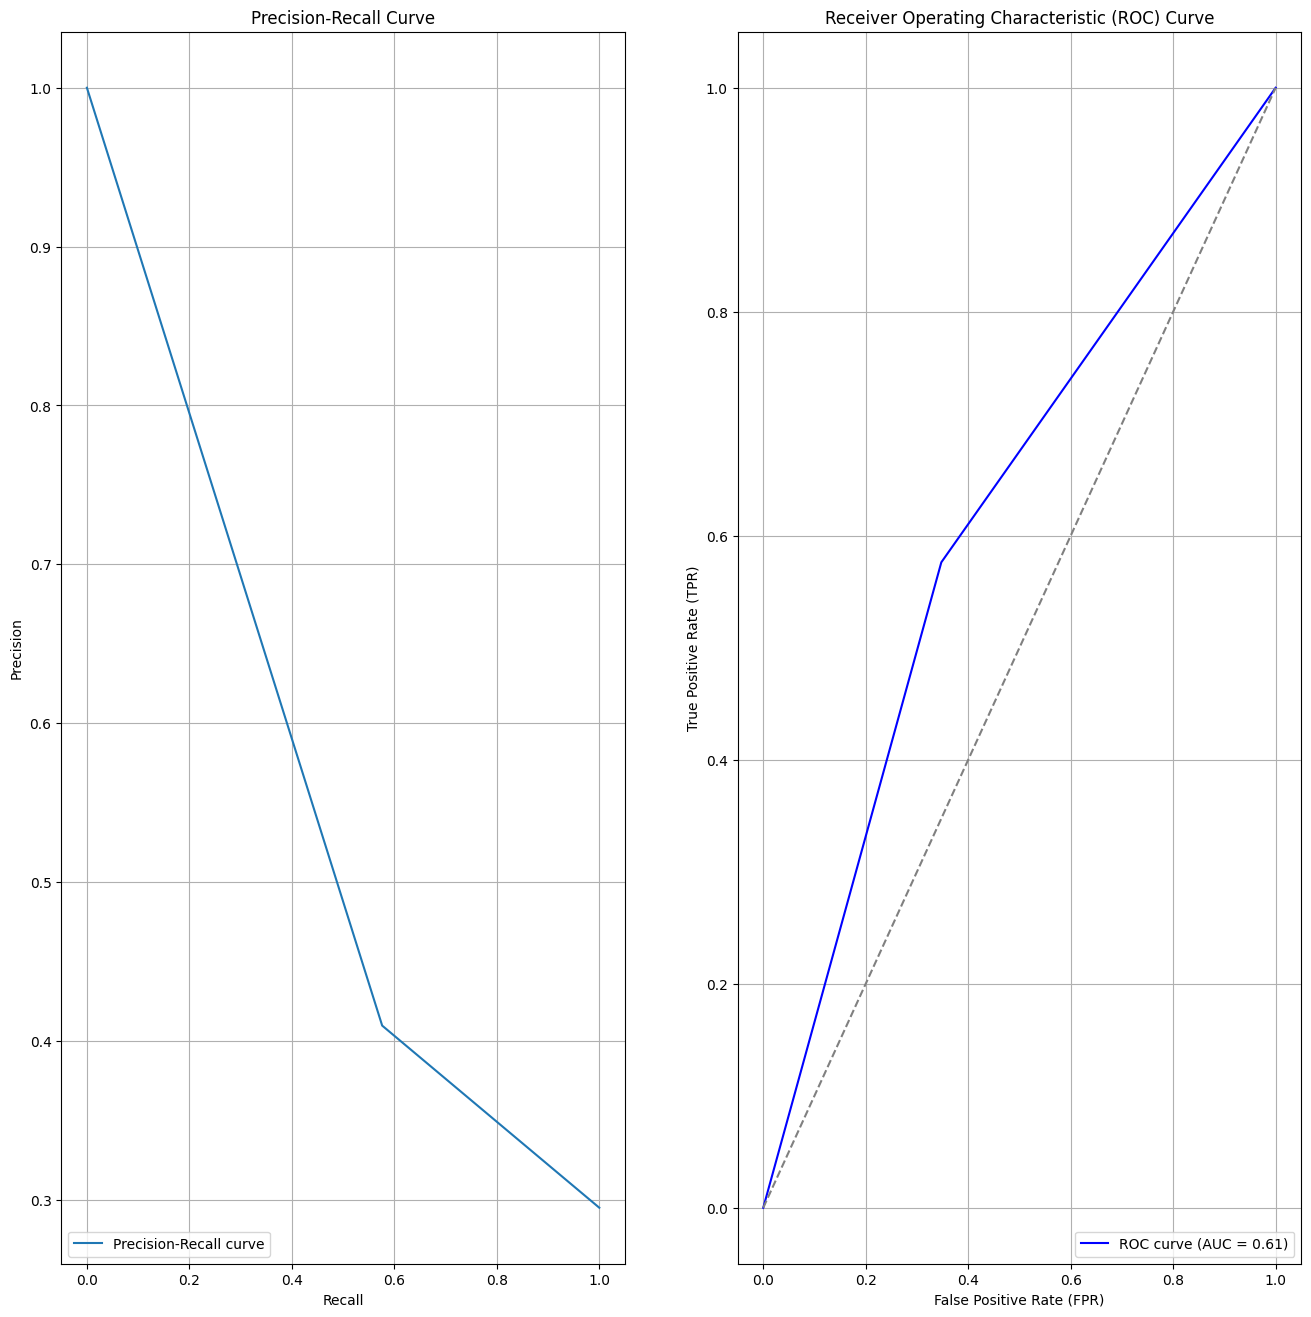

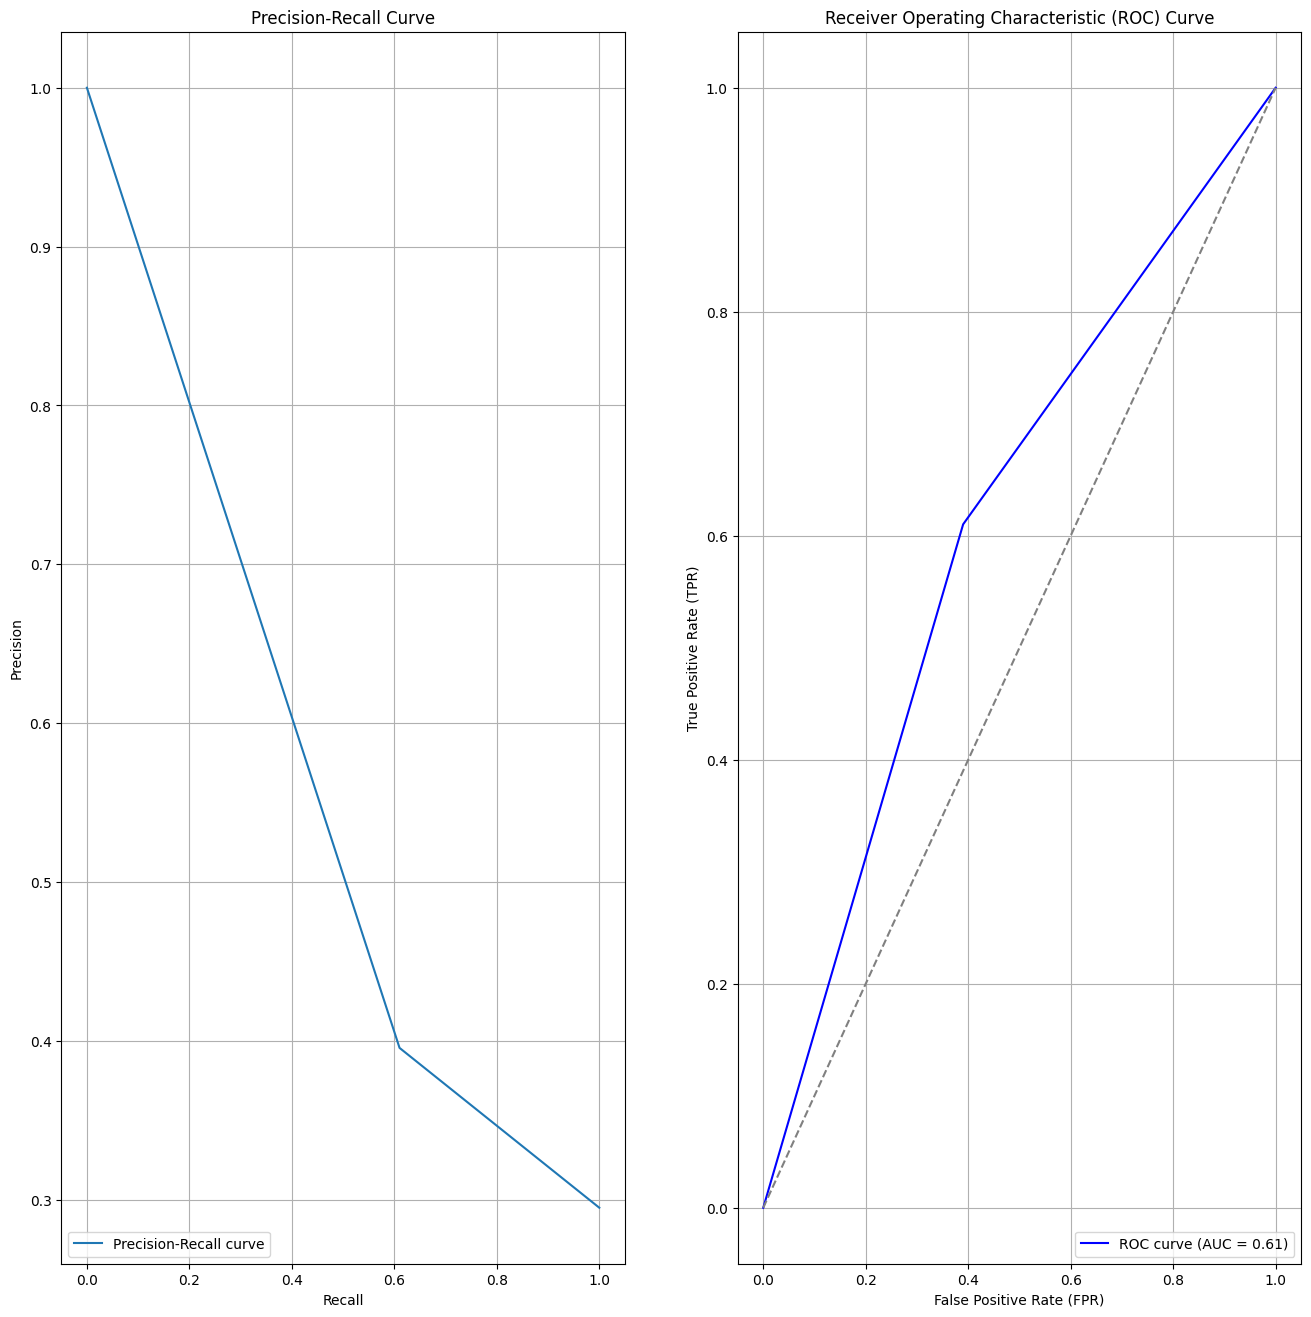

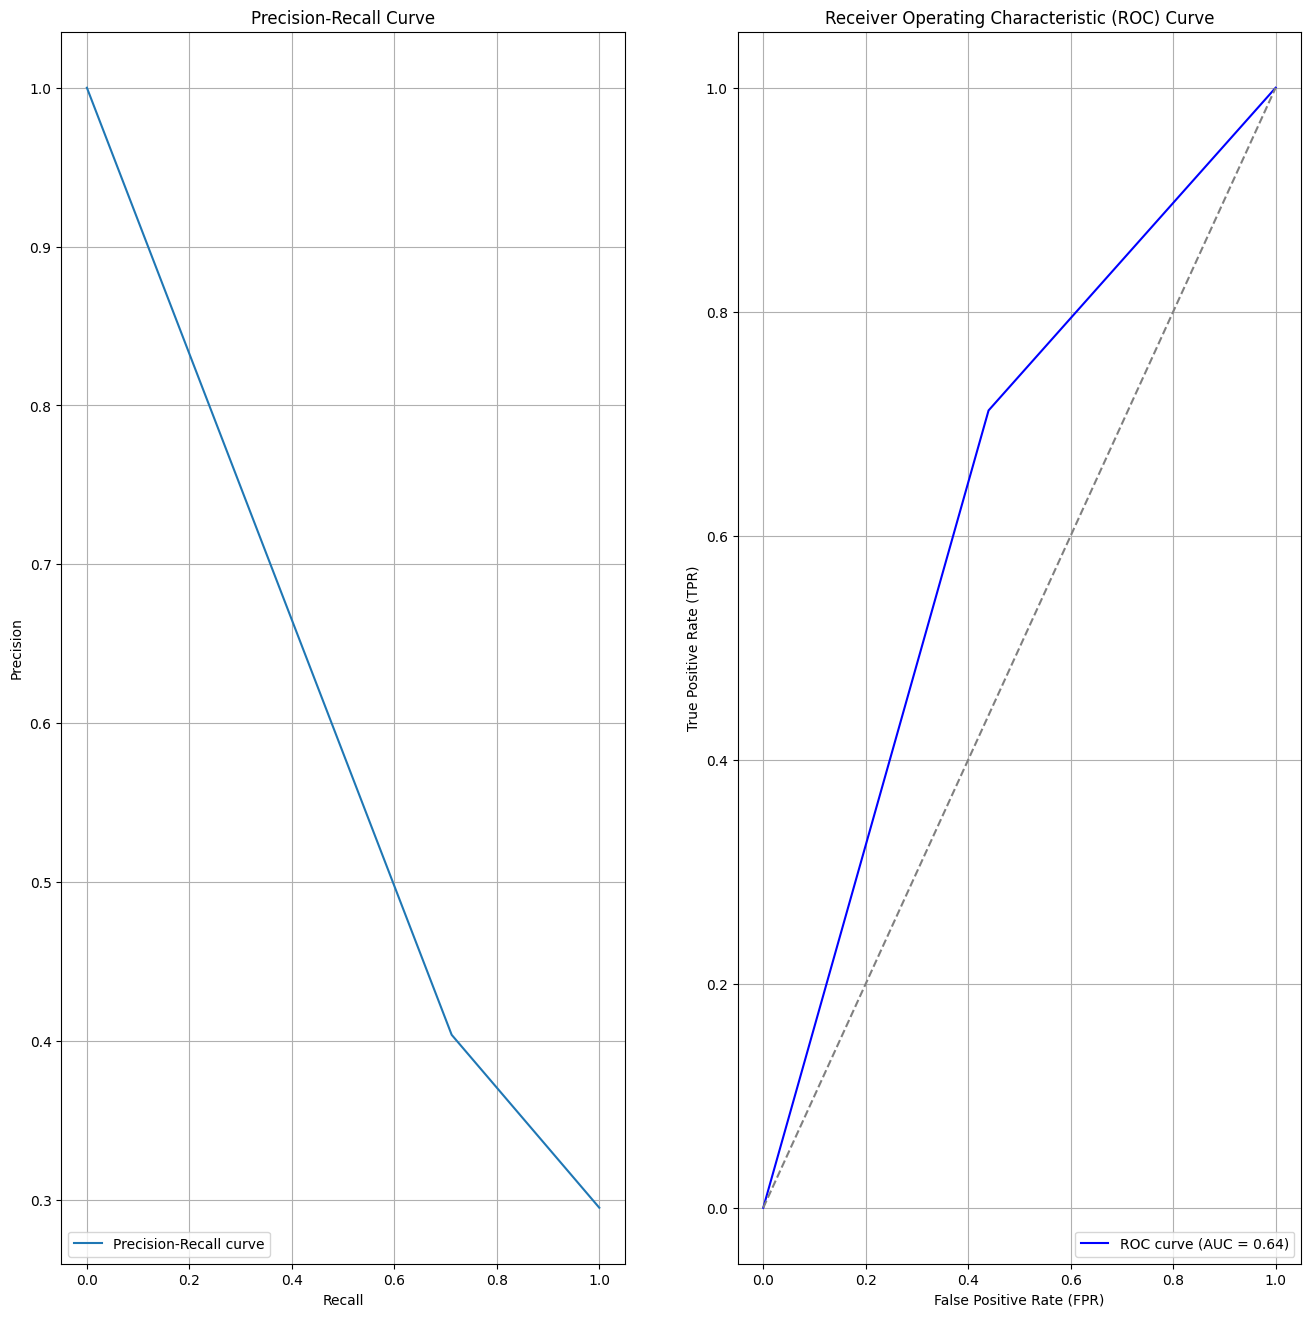

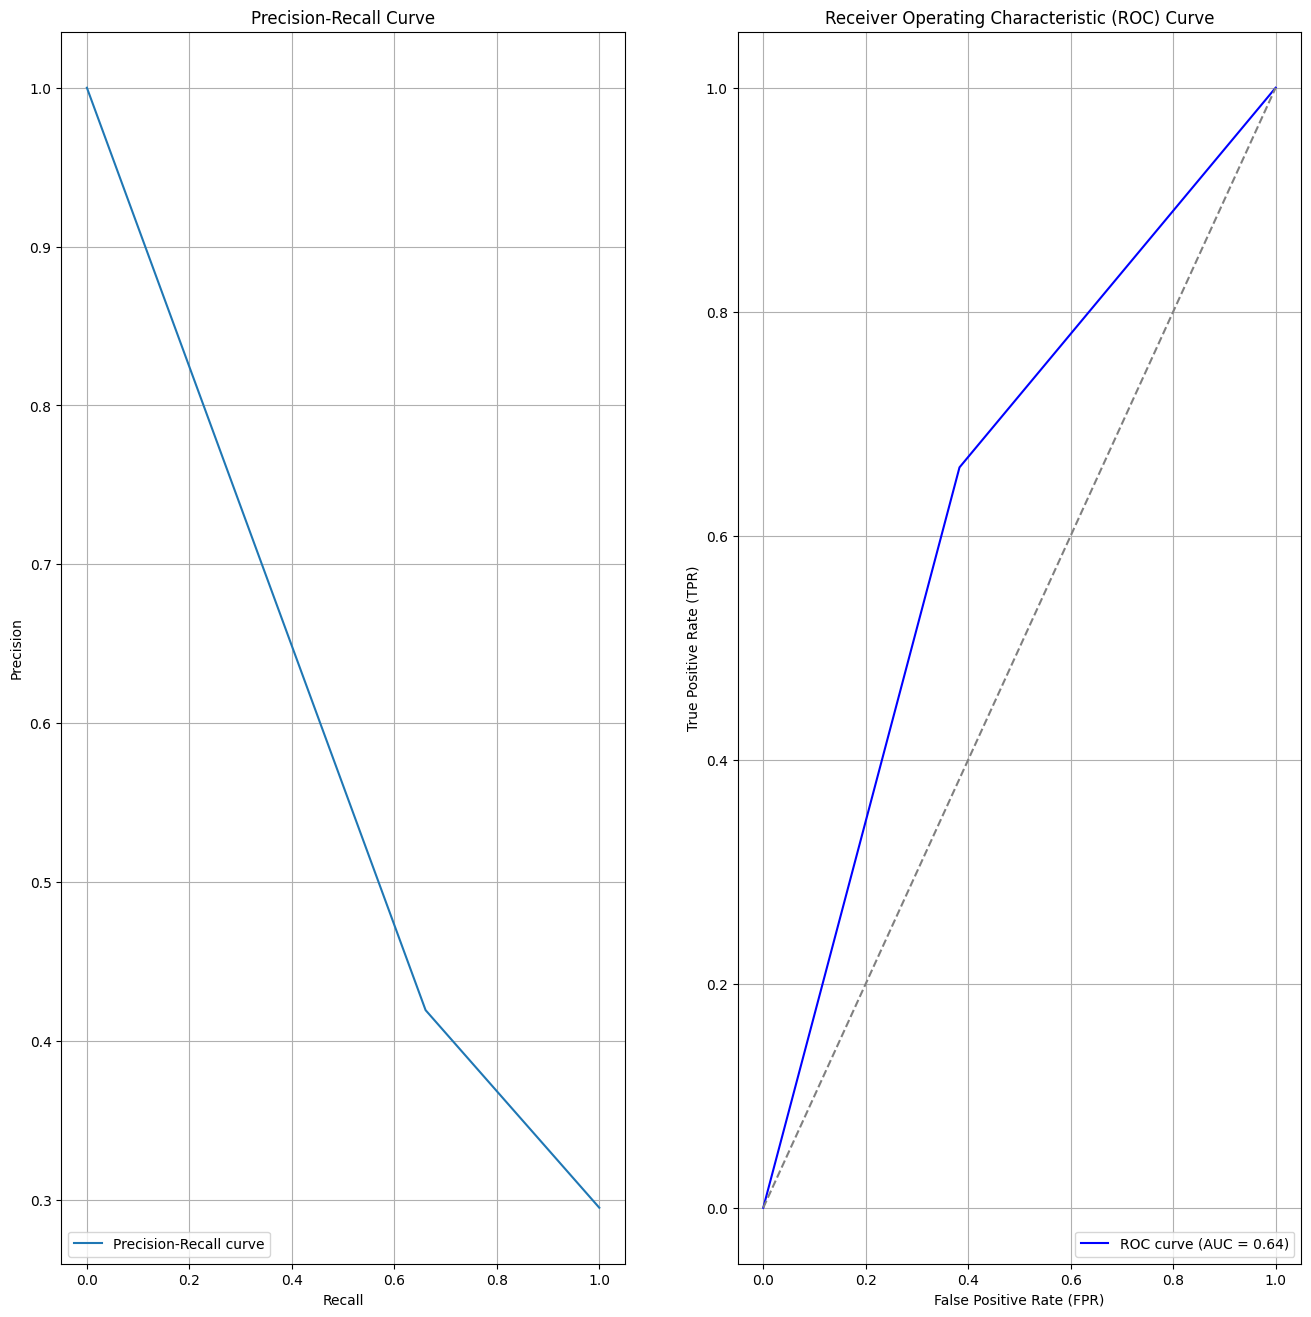

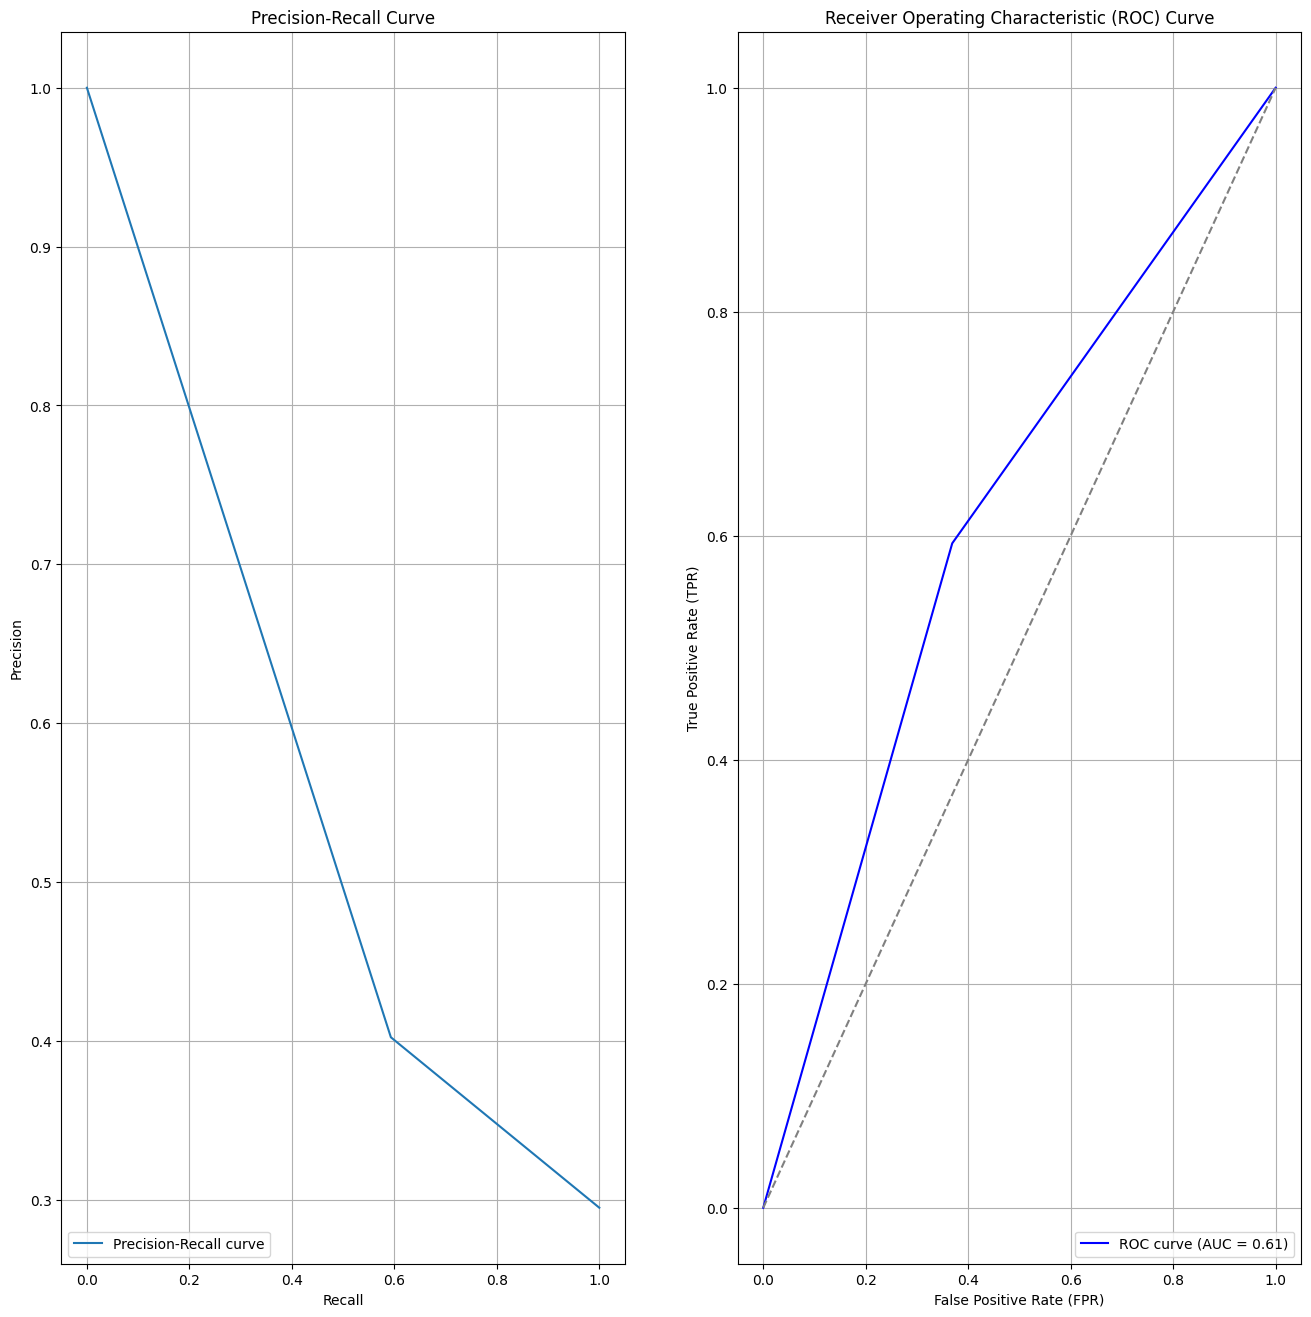

Time taken to run the whole workflow 50 times (sec):  1204.0515072345734


In [18]:
import time
accuracy_list = []
recall_list = []
f1_list =[]
start = time.time()
for i in range(51):
    weights = np.random.randn(n_layers, n_qubits, 3)
    X_reservoir = get_nqs_outputs(X_pca, weights)
    X_train, X_test, y_train, y_test = train_test_split(X_reservoir, y, test_size=0.2, random_state=42)
    
    base_learners = [
    ('lr', LogisticRegression(class_weight='balanced', random_state=42)),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('xgb', xgb.XGBClassifier(scale_pos_weight=10, random_state=42))
    ]
    # Define the final estimator with class weights
    final_estimator = LogisticRegression(class_weight='balanced', random_state=42)

    # Create the stacking model
    stacking_model = StackingClassifier(estimators=base_learners, final_estimator=final_estimator)

    # Train the model on the training data
    stacking_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_stacking = stacking_model.predict(X_test)

    # Evaluate the performance of the stacked model
    accuracy_list.append(accuracy_score(y_test, y_pred_stacking))
    recall_list.append(recall_score(y_test, y_pred_stacking))
    f1_list.append(f1_score(y_test, y_pred_stacking))
    
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_stacking)
    # Calculate ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_stacking)

    # Compute ROC AUC score
    roc_auc = auc(fpr, tpr)

    # Plot Precision-Recall curve
    plt.figure(figsize=(16, 16))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)  

    # Plot ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)

plt.show()  
End = time.time() - start
print("Time taken to run the whole workflow 50 times (sec): ", End)
    

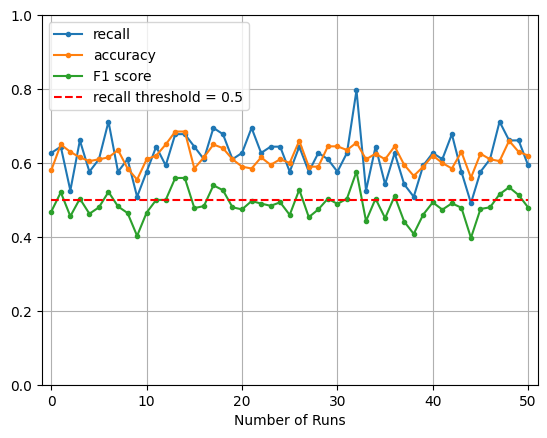

In [21]:
plt.plot(recall_list, label = 'recall', marker = '.')
plt.plot(accuracy_list, label = 'accuracy', marker = '.')
plt.plot(f1_list, label = 'F1 score', marker = '.')
plt.plot([0.5 for i in range(51)], label = 'recall threshold = 0.5', ls ='--', color = 'red')
plt.axis([-1, 51, 0, 1])
plt.xlabel('Number of Runs')
plt.legend()
plt.grid()
plt.show()

In [22]:
print("Recall Values for 50 runs : ", [round(i, 2) for i in recall_list])

Recall Values for 50 runs :  [0.63, 0.64, 0.53, 0.66, 0.58, 0.61, 0.71, 0.58, 0.61, 0.51, 0.58, 0.64, 0.59, 0.68, 0.68, 0.64, 0.61, 0.69, 0.68, 0.61, 0.63, 0.69, 0.63, 0.64, 0.64, 0.58, 0.64, 0.58, 0.63, 0.61, 0.58, 0.63, 0.8, 0.53, 0.64, 0.54, 0.63, 0.54, 0.51, 0.59, 0.63, 0.61, 0.68, 0.58, 0.49, 0.58, 0.61, 0.71, 0.66, 0.66, 0.59]


In [23]:
print("F1 Scores for 50 runs : ", [round(i, 2) for i in f1_list])

F1 Scores for 50 runs :  [0.47, 0.52, 0.46, 0.5, 0.46, 0.48, 0.52, 0.48, 0.46, 0.4, 0.47, 0.5, 0.5, 0.56, 0.56, 0.48, 0.48, 0.54, 0.53, 0.48, 0.47, 0.5, 0.49, 0.48, 0.49, 0.46, 0.53, 0.45, 0.47, 0.5, 0.49, 0.5, 0.58, 0.44, 0.5, 0.45, 0.51, 0.44, 0.41, 0.46, 0.49, 0.47, 0.49, 0.48, 0.4, 0.48, 0.48, 0.52, 0.53, 0.51, 0.48]


In [24]:
print("Accuracy Values for 50 runs : ", [round(i, 2) for i in accuracy_list])

Accuracy Values for 50 runs :  [0.58, 0.65, 0.63, 0.62, 0.6, 0.61, 0.62, 0.64, 0.58, 0.56, 0.61, 0.62, 0.65, 0.68, 0.68, 0.58, 0.62, 0.65, 0.64, 0.61, 0.59, 0.58, 0.62, 0.6, 0.61, 0.6, 0.66, 0.59, 0.59, 0.64, 0.64, 0.64, 0.66, 0.61, 0.62, 0.61, 0.64, 0.6, 0.56, 0.59, 0.62, 0.6, 0.58, 0.63, 0.56, 0.62, 0.61, 0.6, 0.66, 0.63, 0.62]
